In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
from scipy import stats
from shapely.geometry import Polygon
from sklearn.metrics import auc
from scipy.interpolate import interp1d

### **Read Dataset**

In [6]:
anno_df = pd.read_csv('data/anno_df.csv')
anno_df.head()

,Unnamed: 0,filename,image_id,id,defect_class_id,label,xy,x,y
0,0,1g_04.png,624,175683,7,Mononukleäre Zelle,"1354,1377.48,1330.52,1389.22,1330.52,1412.699,...","[1354.0, 1330.52, 1330.52, 1350.087, 1357.913,...","[1377.48, 1389.22, 1412.699, 1424.439, 1420.52..."
1,1,1g_04.png,624,175664,7,Mononukleäre Zelle,"223.058,1804.029,199.578,1800.116,191.751,1815...","[223.058, 199.578, 191.751, 203.491, 223.058, ...","[1804.029, 1800.116, 1815.769, 1831.422, 1835...."
2,2,1g_04.png,624,175634,7,Mononukleäre Zelle,"1549.665,1005.717,1545.751,1013.543,1541.838,1...","[1549.665, 1545.751, 1541.838, 1541.838, 1557....","[1005.717, 1013.543, 1021.37, 1037.023, 1037.0..."
3,3,1g_04.png,624,175654,7,Mononukleäre Zelle,"661.347,1678.803,637.867,1667.064,614.387,1674...","[661.347, 637.867, 614.387, 622.214, 630.04, 6...","[1678.803, 1667.064, 1674.89, 1698.37, 1694.45..."
4,4,1g_04.png,624,175633,7,Mononukleäre Zelle,"1784.462,1897.948,1796.202,1886.208,1804.029,1...","[1784.462, 1796.202, 1804.029, 1780.549, 1772....","[1897.948, 1886.208, 1870.555, 1858.815, 1862...."


In [7]:
pred_df = pd.read_csv('data/pred_df.csv')
pred_df.head()

,Unnamed: 0,image_id,prediction_id,confidence,polygon_id,prediction_class,xy
0,0,3165,23699,0.431523,1937097,Defect,"37.578460693359375,13.887542724609375,37.31016..."
1,1,3165,23699,0.603884,1937098,Defect,"231.45407104492188,9.646164820744442,225.45407..."
2,2,3165,23699,0.244653,1937099,Defect,"318.3146711077009,33.736045837402344,316.76688..."
3,3,3165,23699,0.916268,1937100,Defect,"395.9158020019531,82.97906857445126,387.915802..."
4,4,3165,23699,0.366087,1937101,Defect,"337.0517883300781,84.71218928584346,332.051788..."


###  **Initial Exploration**

**1. Manually Collected (Ground Truth) — anno_df:**
- Has 3,648 entries

    Key columns:
- `image_id`: image reference
- `defect_class_id`: defect category
- `label`: readable label (e.g., "Mononukleäre Zelle")
- `x,y,xy`: coordinate data for bounding polygons (object location)

**2. Model Predictions (Generated) — pred_df:**
- Has 7,118 entries

    Key columns:
- `image_id`: to match with anno_df
- `confidence`: model's confidence for each prediction
- `prediction_class`: predicted class (e.g., "Defect")
- `xy`: predicted polygon

**Takeaways**
- We have 3,648 manual annotations vs 7,118 predictions
- This suggests the system is generating roughly twice as many predictions as there are actual defects
- No missing values
- Each dataset has unique 48 images.
- Single `defect_class` in anno_df and single `prediction_class` in pred_df

In [8]:
def basic_dataset_info(df, name):
    """Print basic information about the dataset"""
    print(f"\n=== {name} Dataset Analysis ===")
    print("\nBasic Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nUnique Values:")
    print(df.nunique())

In [9]:
basic_dataset_info(anno_df, "Annotation")


=== Annotation Dataset Analysis ===

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       3648 non-null   int64 
 1   filename         3648 non-null   object
 2   image_id         3648 non-null   int64 
 3   id               3648 non-null   int64 
 4   defect_class_id  3648 non-null   int64 
 5   label            3648 non-null   object
 6   xy               3648 non-null   object
 7   x                3648 non-null   object
 8   y                3648 non-null   object
dtypes: int64(4), object(5)
memory usage: 256.6+ KB
None

Summary Statistics:
        Unnamed: 0     image_id            id  defect_class_id
count  3648.000000  3648.000000  3.648000e+03           3648.0
mean   1823.500000  1952.283717  9.417104e+05              7.0
std    1053.231219   831.767822  5.353460e+05              0.0
min       0.000000 

In [10]:
basic_dataset_info(pred_df, "Prediction")


=== Prediction Dataset Analysis ===

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7118 entries, 0 to 7117
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7118 non-null   int64  
 1   image_id          7118 non-null   int64  
 2   prediction_id     7118 non-null   int64  
 3   confidence        7118 non-null   float64
 4   polygon_id        7118 non-null   int64  
 5   prediction_class  7118 non-null   object 
 6   xy                7118 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 389.4+ KB
None

Summary Statistics:
        Unnamed: 0     image_id  prediction_id   confidence    polygon_id
count  7118.000000  7118.000000    7118.000000  7118.000000  7.118000e+03
mean   3558.500000  1951.781540   23720.931863     0.512246  1.940022e+06
std    2054.933941   813.485715      14.282011     0.302539  2.054934e+03
min       0.000000   624.000000   2

#### **Integrity & Overlap Checks**

**image_ids alignment across datasets**
1. Both datasets contain exactly 48 unique images (no missing images in either dataset)
2. Every single image has more predictions than annotations
3. On average, there are 1.95 predictions for every annotation
4. The difference ranges from as low as 2 extra predictions (image 2323) to as high as 183 extra predictions (image 2879)
5. Notable Cases:
    - Lowest annotation count: Image 653 (8 annotations, 14 predictions)
    - Highest annotation count: Image 3161 (228 annotations, 353 predictions)
    - Most over-predicted: Image 2879 (183 more predictions than annotations)
    - Most closely matched: Image 2323 (only 2 more predictions than annotations)
Insights:
1. The model is over-predicting defects (about twice as many predictions as ground truth)
2. The over-prediction is consistent across all images
3. There's significant variation in how many extra predictions are made per image

**Confidence Score Distribution:**
- Median confidence is 0.47
- There's a wide spread of confidence scores (std: 0.30)
- 25% of predictions have confidence > 0.82
- All predictions have at least 0.10 confidence
- The predictions have confidence scores ranging from 0.10 to 0.99, with a mean of 0.51
- There's significant variation in confidence scores


In [42]:
# Get unique image_ids from both datasets
anno_images = set(anno_df['image_id'].unique())
pred_images = set(pred_df['image_id'].unique())

print("=== Image ID Alignment Analysis ===")
print(f"\nTotal unique images in annotations: {len(anno_images)}")
print(f"Total unique images in predictions: {len(pred_images)}")

# Find images that are in annotations but not in predictions
missing_in_pred = anno_images - pred_images
if missing_in_pred:
    print(f"\nImages in annotations but missing in predictions: {sorted(missing_in_pred)}")

# Find images that are in predictions but not in annotations
missing_in_anno = pred_images - anno_images
if missing_in_anno:
    print(f"\nImages in predictions but missing in annotations: {sorted(missing_in_anno)}")

# For images present in both datasets
common_images = anno_images.intersection(pred_images)
print(f"\nImages present in both datasets: {len(common_images)}")

# Compare counts for each image
print("\nDefect counts comparison for common images:")
print("image_id | Annotations | Predictions | Difference")
print("-" * 50)
for img_id in sorted(common_images):
    anno_count = len(anno_df[anno_df['image_id'] == img_id])
    pred_count = len(pred_df[pred_df['image_id'] == img_id])
    diff = pred_count - anno_count
    print(f"{img_id:8d} | {anno_count:11d} | {pred_count:11d} | {diff:10d}")

# Calculate average predictions per annotation
total_annotations = len(anno_df)
total_predictions = len(pred_df)
print(f"\nAverage predictions per annotation: {total_predictions/total_annotations:.2f}")


=== Image ID Alignment Analysis ===

Total unique images in annotations: 48
Total unique images in predictions: 48

Images present in both datasets: 48

Defect counts comparison for common images:
image_id | Annotations | Predictions | Difference
--------------------------------------------------
     624 |          75 |         111 |         36
     627 |         128 |         194 |         66
     631 |          78 |         131 |         53
     645 |          53 |         103 |         50
     646 |          92 |         181 |         89
     648 |          64 |         151 |         87
     653 |           8 |          14 |          6
     654 |          26 |          57 |         31
     655 |          42 |          99 |         57
    1177 |         105 |         219 |        114
    1180 |          38 |          88 |         50
    1195 |          14 |          51 |         37
    1199 |          75 |         172 |         97
    1203 |          62 |         141 |         79
  

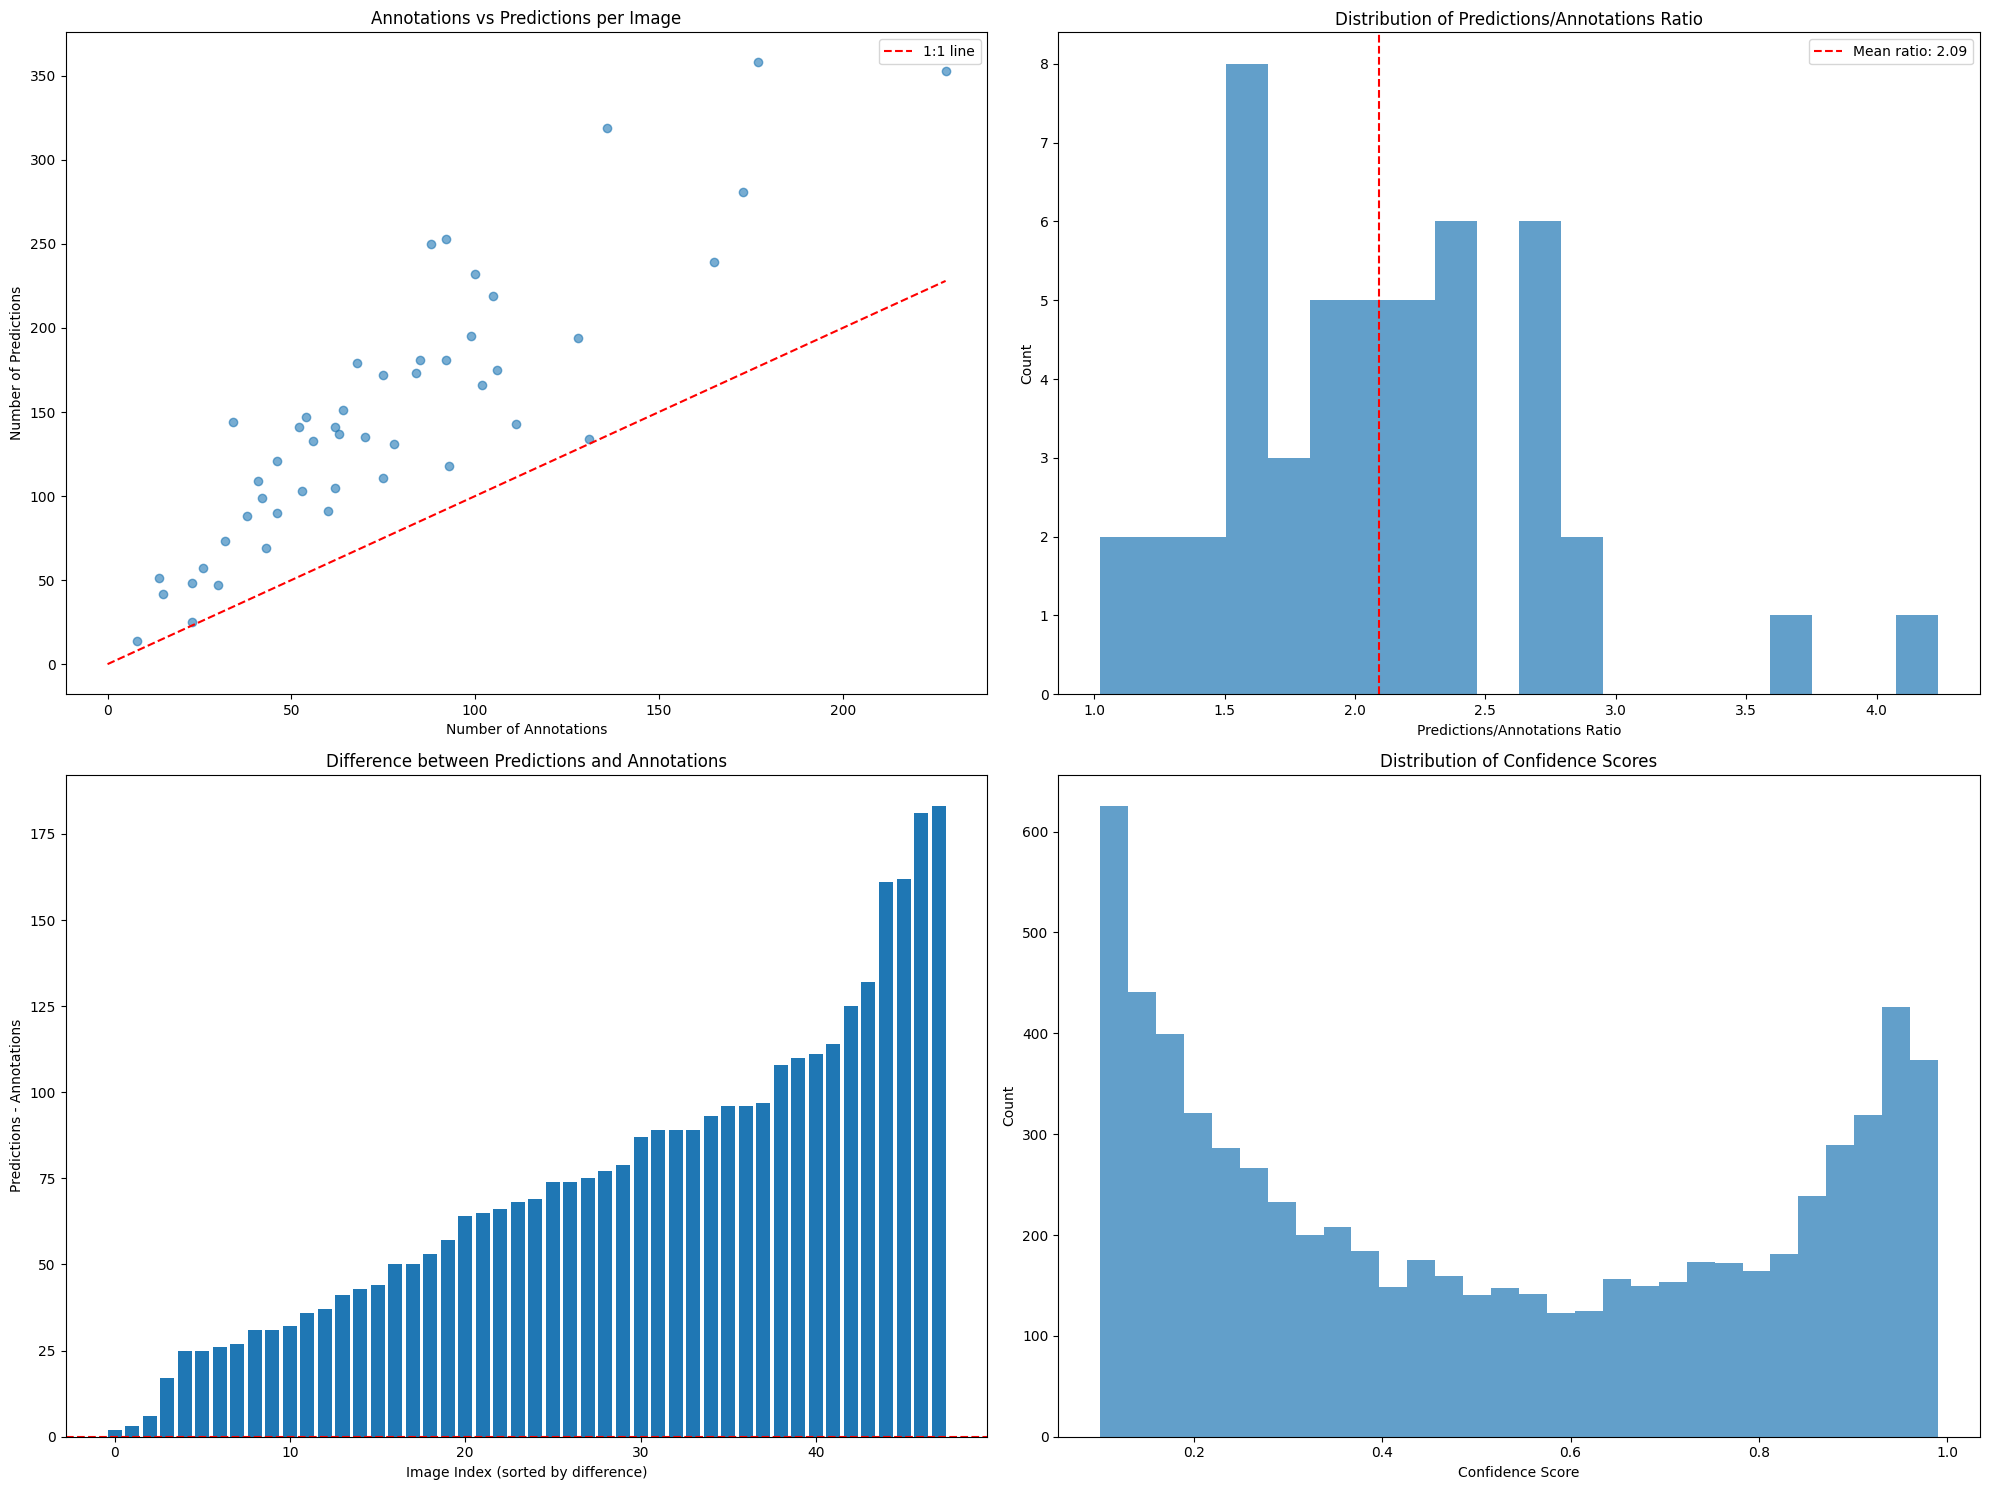

=== Summary Statistics ===

Average predictions per annotation: 1.95

Predictions/Annotations ratio per image:
count    48.000000
mean      2.092407
std       0.612115
min       1.022901
25%       1.626658
50%       2.072619
75%       2.357701
max       4.235294
dtype: float64

Confidence score statistics:
count    7118.000000
mean        0.512246
std         0.302539
min         0.100062
25%         0.218224
50%         0.468183
75%         0.820323
max         0.990468
Name: confidence, dtype: float64

Correlation between number of annotations and prediction/annotation ratio: -0.385


In [45]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Scatter plot: Annotations vs Predictions per image
plt.subplot(2, 2, 1)
image_counts = pd.DataFrame({
    'annotations': anno_df.groupby('image_id').size(),
    'predictions': pred_df.groupby('image_id').size()
})
plt.scatter(image_counts['annotations'], image_counts['predictions'], alpha=0.6)
plt.plot([0, image_counts['annotations'].max()], [0, image_counts['annotations'].max()], 
         'r--', label='1:1 line')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Predictions')
plt.title('Annotations vs Predictions per Image')
plt.legend()

# 2. Distribution of prediction/annotation ratio
plt.subplot(2, 2, 2)
ratio = image_counts['predictions'] / image_counts['annotations']
plt.hist(ratio, bins=20, alpha=0.7)
plt.axvline(ratio.mean(), color='r', linestyle='--', label=f'Mean ratio: {ratio.mean():.2f}')
plt.xlabel('Predictions/Annotations Ratio')
plt.ylabel('Count')
plt.title('Distribution of Predictions/Annotations Ratio')
plt.legend()

# 3. Bar plot: Difference between predictions and annotations
plt.subplot(2, 2, 3)
difference = image_counts['predictions'] - image_counts['annotations']
plt.bar(range(len(difference)), sorted(difference))
plt.xlabel('Image Index (sorted by difference)')
plt.ylabel('Predictions - Annotations')
plt.title('Difference between Predictions and Annotations')
plt.axhline(y=0, color='r', linestyle='--')

# 4. Confidence score distribution by match status
plt.subplot(2, 2, 4)
plt.hist(pred_df['confidence'], bins=30, alpha=0.7)
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Distribution of Confidence Scores')

plt.tight_layout()
plt.show()

# Print some summary statistics
print("=== Summary Statistics ===")
print(f"\nAverage predictions per annotation: {len(pred_df)/len(anno_df):.2f}")
print("\nPredictions/Annotations ratio per image:")
print(ratio.describe())
print("\nConfidence score statistics:")
print(pred_df['confidence'].describe())

# Calculate correlation between number of annotations and prediction accuracy
correlation = image_counts['annotations'].corr(ratio)
print(f"\nCorrelation between number of annotations and prediction/annotation ratio: {correlation:.3f}")

### **Matching Results Analysis**
- True Positives: 3,111 (matched predictions with IoU > 0.5)
- False Positives: 4,007 (predictions that didn't match any annotation)
- False Negatives: 537 (annotations that weren't matched by any prediction)
- IoU Quality for True Positives:
    - Mean IoU: 0.79 (very good overlap)
    - Minimum IoU: 0.50 (our threshold)
    - 75% of matches have IoU > 0.75 (excellent overlap)
- Confidence Score Distribution:
    - True Positives:
        - Mean confidence: 0.71
        - Median confidence: 0.80
        - 75% have confidence > 0.53
    - False Positives:
        - Mean confidence: 0.36
        - Median confidence: 0.27
        75% have confidence < 0.51
    - True Positives have significantly higher confidence (mean: 0.71) than False - - Positives (mean: 0.36)
    - The difference is statistically significant (t-test p-value ≈ 0)
    - There's clear separation between TP and FP distributions, but with some overlap
- IoU vs Confidence Relationship:
    - There's a positive correlation between confidence and IoU for true positives
    - Higher confidence ranges tend to have slightly better IoU:
        - 0.00-0.25: Mean IoU = 0.768
        - 0.25-0.50: Mean IoU = 0.767
        - 0.50-0.75: Mean IoU = 0.779
        - 0.75-1.00: Mean IoU = 0.796
    - The improvement in IoU with confidence is modest but consistent
- Optimal Threshold:
    - Based on F1 score optimization, the recommended confidence threshold is 0.40
    - This threshold achieves an F1 score of 0.679
    - This balances precision (reducing false positives) with recall (maintaining true positives)

**Insights**
- There's a clear separation in confidence scores between true and false positives
- The matching quality (IoU) for true positives is very good
- The model has a high false positive rate but good recall (few false negatives)
- The model is quite good at assigning higher confidence to true matches
- False positives tend to have lower confidence scores
- IoU quality improves with confidence, suggesting more confident predictions are more accurate
- There's a clear separation point around 0.40 confidence that optimizes the precision-recall trade-off

In [55]:
def string_to_coords(xy_str):
    """Convert string coordinates to list of tuples"""
    try:
        # Handle string representations of lists
        if isinstance(xy_str, str):
            if xy_str.startswith('['):
                coords = ast.literal_eval(xy_str)
            else:
                coords = [float(x) for x in xy_str.split(',')]
            return list(zip(coords[::2], coords[1::2]))
        return None
    except:
        return None

def calculate_iou(poly1_coords, poly2_coords):
    """Calculate IoU between two polygons"""
    try:
        poly1 = Polygon(poly1_coords)
        poly2 = Polygon(poly2_coords)
        
        if not (poly1.is_valid and poly2.is_valid):
            return 0.0
        
        intersection_area = poly1.intersection(poly2).area
        union_area = poly1.union(poly2).area
        
        if union_area == 0:
            return 0.0
            
        return intersection_area / union_area
    except:
        return 0.0

def match_polygons(anno_df, pred_df, iou_threshold=0.5):
    """Match predictions to annotations based on IoU"""
    results = []
    
    # Process each image separately
    for image_id in tqdm(anno_df['image_id'].unique()):        
        # Get annotations and predictions for this image
        image_annos = anno_df[anno_df['image_id'] == image_id]
        image_preds = pred_df[pred_df['image_id'] == image_id]
        
        # Convert coordinates to polygon format
        anno_polygons = []
        for _, anno in image_annos.iterrows():
            coords = string_to_coords(anno['xy'])
            if coords:
                anno_polygons.append({
                    'coords': coords,
                    'id': anno['id'],
                    'class': anno['defect_class_id'],
                    'matched': False
                })
        
        pred_polygons = []
        for _, pred in image_preds.iterrows():
            coords = string_to_coords(pred['xy'])
            if coords:
                pred_polygons.append({
                    'coords': coords,
                    'id': pred['prediction_id'],
                    'confidence': pred['confidence'],
                    'class': pred['prediction_class'],
                    'matched': False
                })
        
        # Calculate IoU between all pairs
        for pred in pred_polygons:
            best_iou = 0
            best_anno = None
            
            for anno in anno_polygons:
                if not anno['matched']:  # Only consider unmatched annotations
                    iou = calculate_iou(pred['coords'], anno['coords'])
                    if iou > best_iou:
                        best_iou = iou
                        best_anno = anno
            
            # If we found a match above threshold
            if best_iou >= iou_threshold and best_anno is not None:
                best_anno['matched'] = True
                results.append({
                    'image_id': image_id,
                    'anno_id': best_anno['id'],
                    'pred_id': pred['id'],
                    'anno_class': best_anno['class'],
                    'pred_class': pred['class'],
                    'confidence': pred['confidence'],
                    'iou': best_iou,
                    'match_type': 'true_positive'
                })
            else:
                # False positive
                results.append({
                    'image_id': image_id,
                    'anno_id': None,
                    'pred_id': pred['id'],
                    'anno_class': None,
                    'pred_class': pred['class'],
                    'confidence': pred['confidence'],
                    'iou': best_iou,
                    'match_type': 'false_positive'
                })
        
        # Add unmatched annotations as false negatives
        for anno in anno_polygons:
            if not anno['matched']:
                results.append({
                    'image_id': image_id,
                    'anno_id': anno['id'],
                    'pred_id': None,
                    'anno_class': anno['class'],
                    'pred_class': None,
                    'confidence': None,
                    'iou': 0,
                    'match_type': 'false_negative'
                })
    
    return pd.DataFrame(results)
    
# Match polygons with IoU threshold of 0.5
matches_df = match_polygons(anno_df, pred_df, iou_threshold=0.5)

# Save results
matches_df.to_csv('data/polygon_matches.csv', index=False)

# Print summary statistics
print("\n=== Matching Results ===")
print("\nMatch types distribution:")
print(matches_df['match_type'].value_counts())

print("\nIoU statistics for true positives:")
tp_matches = matches_df[matches_df['match_type'] == 'true_positive']
print(tp_matches['iou'].describe())

print("\nConfidence score statistics for different match types:")
print("\nTrue Positives:")
print(tp_matches['confidence'].describe())
print("\nFalse Positives:")
fp_matches = matches_df[matches_df['match_type'] == 'false_positive']
print(fp_matches['confidence'].describe())


100%|██████████| 48/48 [03:59<00:00,  4.99s/it]


=== Matching Results ===

Match types distribution:
match_type
false_positive    4007
true_positive     3111
false_negative     537
Name: count, dtype: int64

IoU statistics for true positives:
count    3111.000000
mean        0.786008
std         0.070530
min         0.504230
25%         0.746843
50%         0.796452
75%         0.836335
max         0.936462
Name: iou, dtype: float64

Confidence score statistics for different match types:

True Positives:
count    3111.000000
mean        0.707692
std         0.257113
min         0.103593
25%         0.524616
50%         0.798733
75%         0.926508
max         0.990468
Name: confidence, dtype: float64

False Positives:
count    4007.000000
mean        0.360504
std         0.242060
min         0.100062
25%         0.162694
50%         0.274724
75%         0.506709
max         0.984827
Name: confidence, dtype: float64


/var/folders/jn/0b_xwd412532nmd6152zbw1w0000gp/T/ipykernel_3160/1582500150.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


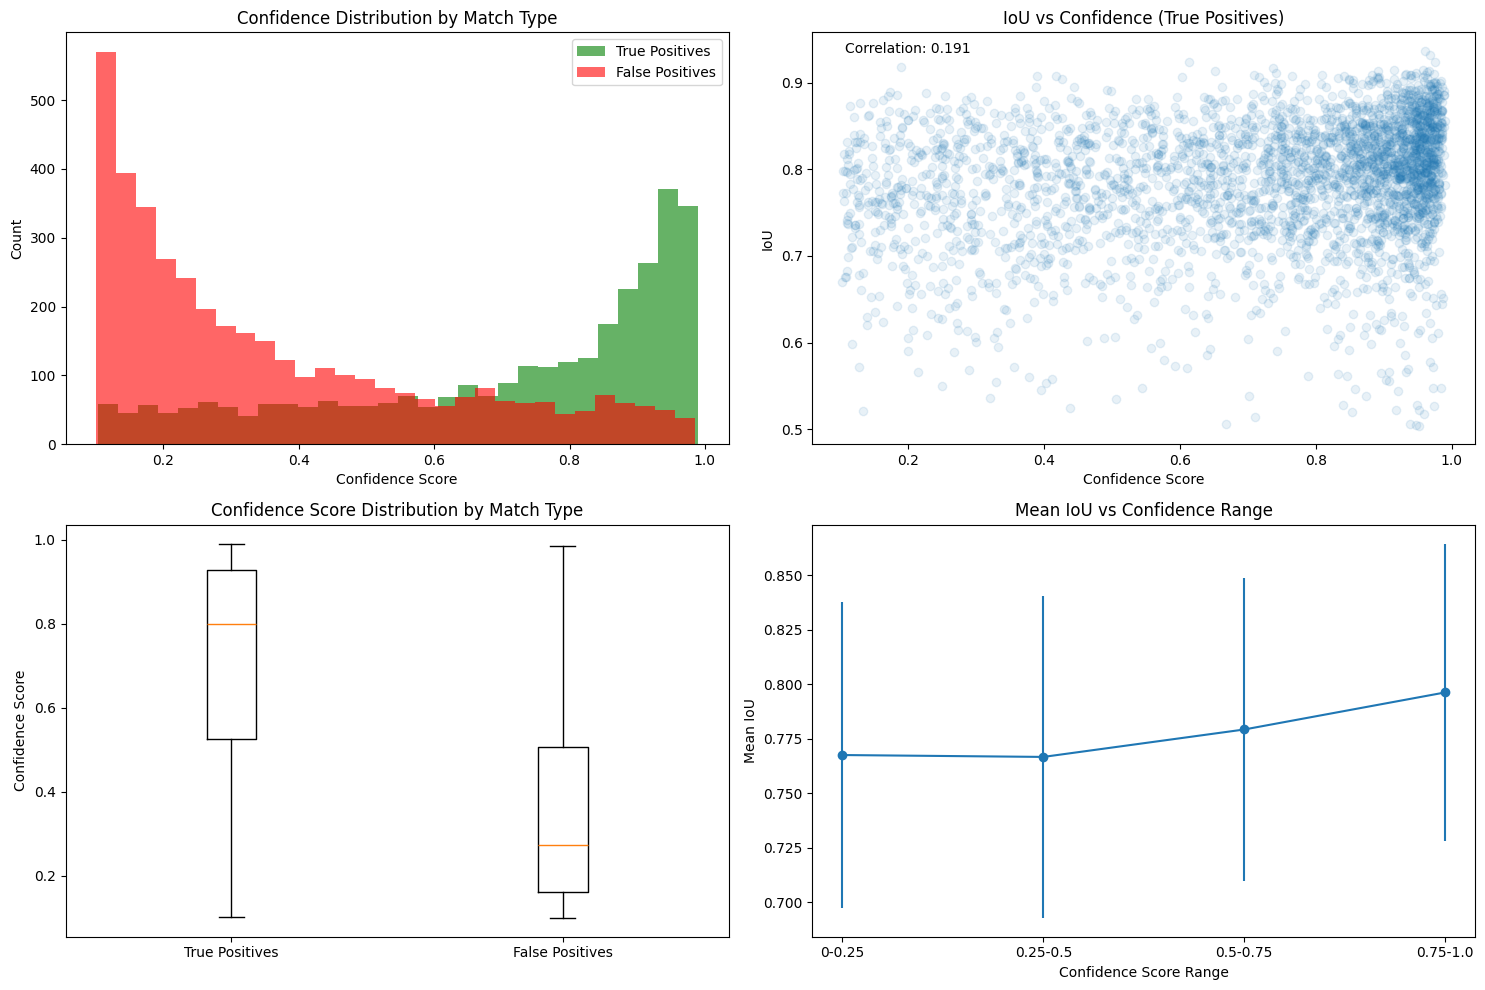

=== Statistical Analysis ===

Confidence Score Statistics:

True Positives:
count    3111.000000
mean        0.707692
std         0.257113
min         0.103593
25%         0.524616
50%         0.798733
75%         0.926508
max         0.990468
Name: confidence, dtype: float64

False Positives:
count    4007.000000
mean        0.360504
std         0.242060
min         0.100062
25%         0.162694
50%         0.274724
75%         0.506709
max         0.984827
Name: confidence, dtype: float64

T-test between TP and FP confidence scores:
t-statistic: 58.409
p-value: 0.000e+00

IoU Statistics by Confidence Range:

Confidence 0.00-0.25:
Count: 253
Mean IoU: 0.768
Std IoU: 0.070

Confidence 0.25-0.50:
Count: 474
Mean IoU: 0.767
Std IoU: 0.074

Confidence 0.50-0.75:
Count: 628
Mean IoU: 0.779
Std IoU: 0.069

Confidence 0.75-1.00:
Count: 1756
Mean IoU: 0.796
Std IoU: 0.068

Recommended confidence threshold (based on F1 score): 0.40
F1 score at this threshold: 0.679


In [56]:
# Read the matches data
matches_df = pd.read_csv('data/polygon_matches.csv')

# Create a figure with multiple subplots
plt.figure(figsize=(15, 10))

# 1. Confidence Distribution by Match Type
plt.subplot(2, 2, 1)
# True Positives
plt.hist(matches_df[matches_df['match_type'] == 'true_positive']['confidence'], 
         bins=30, alpha=0.6, label='True Positives', color='green')
# False Positives
plt.hist(matches_df[matches_df['match_type'] == 'false_positive']['confidence'], 
         bins=30, alpha=0.6, label='False Positives', color='red')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Confidence Distribution by Match Type')
plt.legend()

# 2. IoU vs Confidence Scatter Plot (True Positives only)
plt.subplot(2, 2, 2)
tp_matches = matches_df[matches_df['match_type'] == 'true_positive']
plt.scatter(tp_matches['confidence'], tp_matches['iou'], alpha=0.1)
plt.xlabel('Confidence Score')
plt.ylabel('IoU')
plt.title('IoU vs Confidence (True Positives)')

# Calculate correlation
correlation = tp_matches['confidence'].corr(tp_matches['iou'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes)

# 3. Box Plot of Confidence by Match Type
plt.subplot(2, 2, 3)
plt.boxplot([
    matches_df[matches_df['match_type'] == 'true_positive']['confidence'],
    matches_df[matches_df['match_type'] == 'false_positive']['confidence']
], labels=['True Positives', 'False Positives'])
plt.ylabel('Confidence Score')
plt.title('Confidence Score Distribution by Match Type')

# 4. IoU Distribution for Different Confidence Ranges (True Positives)
plt.subplot(2, 2, 4)
confidence_bins = [0.0, 0.25, 0.5, 0.75, 1.0]
iou_means = []
iou_stds = []
bin_centers = []

for i in range(len(confidence_bins)-1):
    mask = (tp_matches['confidence'] >= confidence_bins[i]) & \
           (tp_matches['confidence'] < confidence_bins[i+1])
    iou_means.append(tp_matches[mask]['iou'].mean())
    iou_stds.append(tp_matches[mask]['iou'].std())
    bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)

plt.errorbar(bin_centers, iou_means, yerr=iou_stds, fmt='o-')
plt.xlabel('Confidence Score Range')
plt.ylabel('Mean IoU')
plt.title('Mean IoU vs Confidence Range')
plt.xticks(bin_centers, ['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1.0'])

plt.tight_layout()
plt.show()

# Print statistical analysis
print("=== Statistical Analysis ===")

# T-test between TP and FP confidence scores
tp_conf = matches_df[matches_df['match_type'] == 'true_positive']['confidence']
fp_conf = matches_df[matches_df['match_type'] == 'false_positive']['confidence']
t_stat, p_value = stats.ttest_ind(tp_conf, fp_conf)

print("\nConfidence Score Statistics:")
print("\nTrue Positives:")
print(tp_conf.describe())
print("\nFalse Positives:")
print(fp_conf.describe())

print(f"\nT-test between TP and FP confidence scores:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.3e}")

# IoU analysis for different confidence ranges
print("\nIoU Statistics by Confidence Range:")
for i in range(len(confidence_bins)-1):
    mask = (tp_matches['confidence'] >= confidence_bins[i]) & \
           (tp_matches['confidence'] < confidence_bins[i+1])
    iou_stats = tp_matches[mask]['iou'].describe()
    print(f"\nConfidence {confidence_bins[i]:.2f}-{confidence_bins[i+1]:.2f}:")
    print(f"Count: {iou_stats['count']:.0f}")
    print(f"Mean IoU: {iou_stats['mean']:.3f}")
    print(f"Std IoU: {iou_stats['std']:.3f}")

# Calculate optimal confidence threshold based on F1 score
thresholds = np.arange(0.1, 1.0, 0.05)
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    # True Positives at this threshold
    tp = len(matches_df[(matches_df['match_type'] == 'true_positive') & 
                       (matches_df['confidence'] >= threshold)])
    # False Positives at this threshold
    fp = len(matches_df[(matches_df['match_type'] == 'false_positive') & 
                       (matches_df['confidence'] >= threshold)])
    # False Negatives (true positives below threshold + original false negatives)
    fn = len(matches_df[(matches_df['match_type'] == 'true_positive') & 
                       (matches_df['confidence'] < threshold)]) + \
         len(matches_df[matches_df['match_type'] == 'false_negative'])
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nRecommended confidence threshold (based on F1 score): {best_threshold:.2f}")
print(f"F1 score at this threshold: {best_f1:.3f}")


- Optimal Thresholds:
    - Maximum F1 Score (Best Overall Performance):
        - Threshold: 0.412
        - Precision: 0.659 (66% of predictions are correct)
        - Recall: 0.700 (70% of actual defects are found)
        - F1 Score: 0.679
    - High Precision Setting:
        - Threshold: 0.743
        - Precision: 0.800 (80% of predictions are correct)
        - Recall: 0.490 (49% of actual defects are found)
        - F1 Score: 0.608
- Trade-offs:
    - Lower thresholds (< 0.412):
        - Higher recall but more false positives
        - Good for applications where missing defects is costly
    - Higher thresholds (> 0.743):
        - Higher precision but more missed defects
        - Good for applications where false alarms are costly
- Recommendations:
    - For balanced performance: Use threshold = 0.412
    - For high-confidence predictions: Use threshold = 0.743
    - The choice depends on the relative cost of false positives vs. false negatives
- Additional Insights:
The precision-recall curve shows a smooth trade-off
There's a significant drop in recall above 0.75 confidence
The model maintains decent precision even at lower thresholds

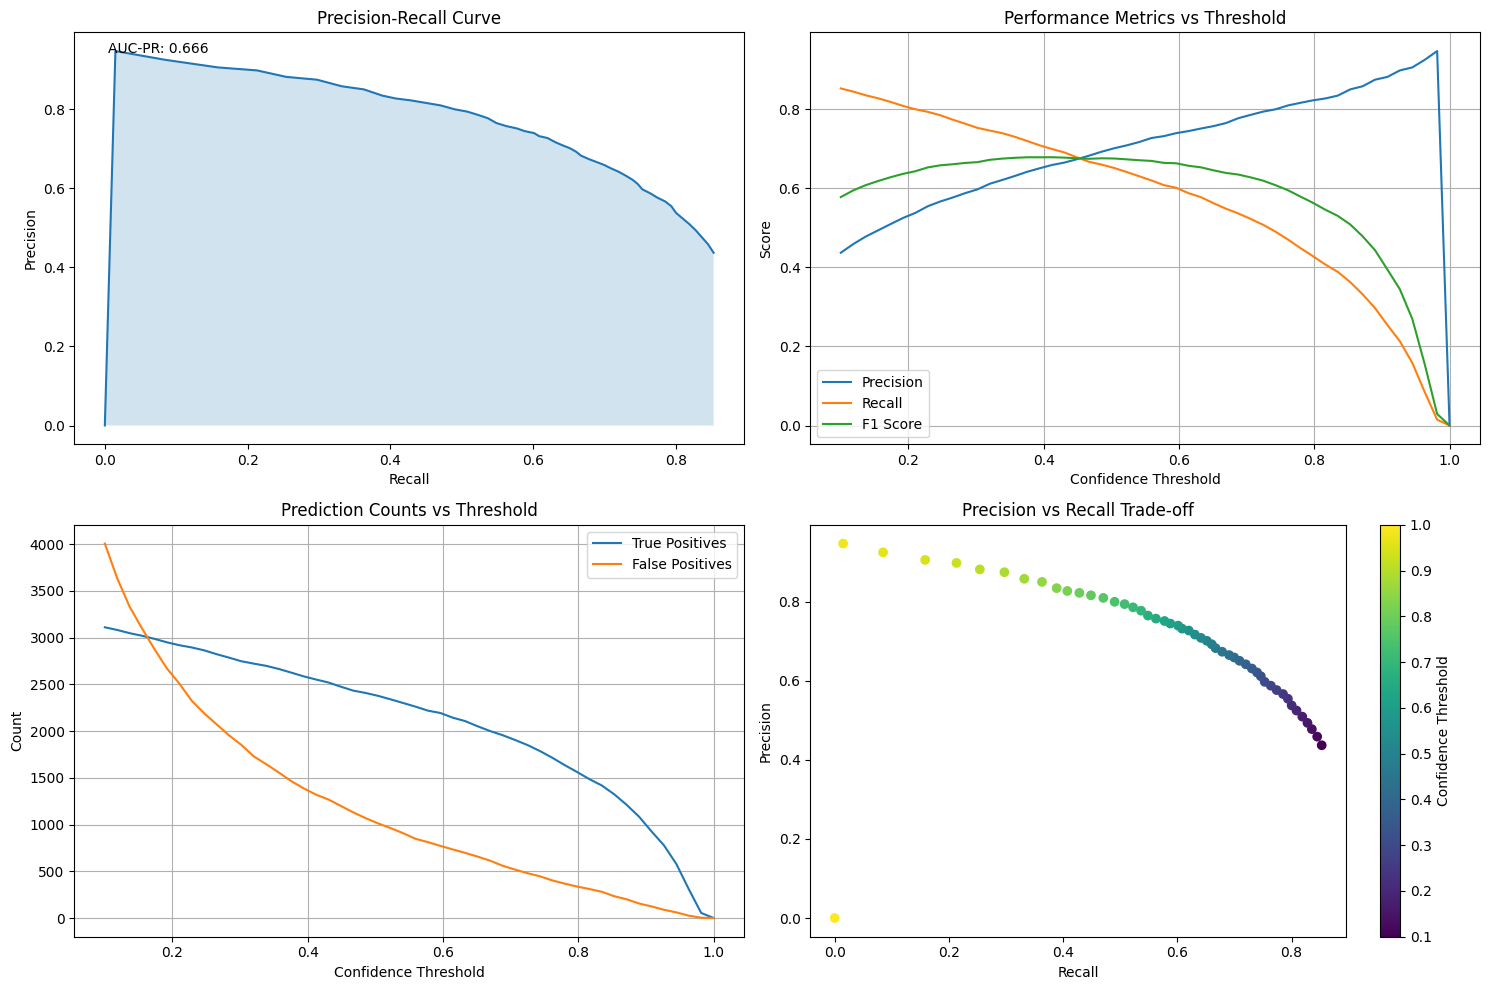

=== Optimal Thresholds Analysis ===

1. Maximum F1 Score:
Threshold: 0.412
Precision: 0.659
Recall: 0.700
F1 Score: 0.679

2. Balanced Precision-Recall:
Threshold: 1.000
Precision: 0.000
Recall: 0.000
F1 Score: 0.000

3. High Precision (>=0.8):
Threshold: 0.743
Precision: 0.800
Recall: 0.490
F1 Score: 0.608


In [60]:
def calculate_metrics(threshold):
    """Calculate precision, recall, and F1 at given threshold"""
    # True Positives at this threshold
    tp = len(matches_df[(matches_df['match_type'] == 'true_positive') & 
                       (matches_df['confidence'] >= threshold)])
    
    # False Positives at this threshold
    fp = len(matches_df[(matches_df['match_type'] == 'false_positive') & 
                       (matches_df['confidence'] >= threshold)])
    
    # False Negatives (true positives below threshold + original false negatives)
    fn = len(matches_df[(matches_df['match_type'] == 'true_positive') & 
                       (matches_df['confidence'] < threshold)]) + \
         len(matches_df[matches_df['match_type'] == 'false_negative'])
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1, tp, fp, fn

# Calculate metrics for different thresholds
thresholds = np.linspace(0.1, 1.0, 50)
results = []

for threshold in thresholds:
    precision, recall, f1, tp, fp, fn = calculate_metrics(threshold)
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })

results_df = pd.DataFrame(results)

# Create figure with multiple subplots
plt.figure(figsize=(15, 10))

# 1. Precision-Recall Curve
plt.subplot(2, 2, 1)
plt.plot(results_df['recall'], results_df['precision'])
plt.fill_between(results_df['recall'], results_df['precision'], alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# Calculate AUC-PR
pr_auc = auc(results_df['recall'], results_df['precision'])
plt.text(0.05, 0.95, f'AUC-PR: {pr_auc:.3f}', transform=plt.gca().transAxes)

# 2. Metrics vs Threshold
plt.subplot(2, 2, 2)
plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
plt.xlabel('Confidence Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs Threshold')
plt.legend()
plt.grid(True)

# 3. True/False Positives vs Threshold
plt.subplot(2, 2, 3)
plt.plot(results_df['threshold'], results_df['tp'], label='True Positives')
plt.plot(results_df['threshold'], results_df['fp'], label='False Positives')
plt.xlabel('Confidence Threshold')
plt.ylabel('Count')
plt.title('Prediction Counts vs Threshold')
plt.legend()
plt.grid(True)

# 4. Precision vs Recall trade-off
plt.subplot(2, 2, 4)
plt.scatter(results_df['recall'], results_df['precision'], 
           c=results_df['threshold'], cmap='viridis')
plt.colorbar(label='Confidence Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall Trade-off')

plt.tight_layout()
plt.show()

# Find optimal thresholds for different criteria
max_f1_idx = results_df['f1'].idxmax()
balanced_idx = (results_df['precision'] - results_df['recall']).abs().idxmin()
high_precision_idx = results_df[results_df['precision'] >= 0.8]['f1'].idxmax()

print("=== Optimal Thresholds Analysis ===")

print("\n1. Maximum F1 Score:")
print(f"Threshold: {results_df.loc[max_f1_idx, 'threshold']:.3f}")
print(f"Precision: {results_df.loc[max_f1_idx, 'precision']:.3f}")
print(f"Recall: {results_df.loc[max_f1_idx, 'recall']:.3f}")
print(f"F1 Score: {results_df.loc[max_f1_idx, 'f1']:.3f}")

print("\n2. Balanced Precision-Recall:")
print(f"Threshold: {results_df.loc[balanced_idx, 'threshold']:.3f}")
print(f"Precision: {results_df.loc[balanced_idx, 'precision']:.3f}")
print(f"Recall: {results_df.loc[balanced_idx, 'recall']:.3f}")
print(f"F1 Score: {results_df.loc[balanced_idx, 'f1']:.3f}")

print("\n3. High Precision (>=0.8):")
if not results_df[results_df['precision'] >= 0.8].empty:
    print(f"Threshold: {results_df.loc[high_precision_idx, 'threshold']:.3f}")
    print(f"Precision: {results_df.loc[high_precision_idx, 'precision']:.3f}")
    print(f"Recall: {results_df.loc[high_precision_idx, 'recall']:.3f}")
    print(f"F1 Score: {results_df.loc[high_precision_idx, 'f1']:.3f}")
else:
    print("No threshold achieves precision >= 0.8")

# Save results for further analysis
results_df.to_csv('threshold_metrics.csv', index=False)


- Confidence Distribution:
    - Overall range: 0.10 to 0.99
    - Mean: 0.51
    - Median: 0.47
    - Strong bimodal distribution (peaks at low and high confidence)

- True Positives vs False Positives:
    - True Positives:
        - Mean confidence: 0.71
        - Median: 0.80
        - 75% above 0.52
    - False Positives:
        - Mean confidence: 0.36
        - Median: 0.27
        - 75% below 0.51

- Confidence Reliability:
    - The model is generally under-confident at high confidence scores
    - Mean calibration error: 0.086
    - High confidence (>0.8) predictions are very reliable:
        - At confidence ≥ 0.8: 82.5% precision
        - At confidence ≥ 0.9: 87.6% precision

- Practical Threshold Recommendations:
    - For high precision (>80%): Use threshold ≥ 0.8
    - For balanced performance: Use threshold around 0.4-0.5
    - For high recall: Use threshold around 0.2-0.3

- Key Observations:
    - Strong separation between true and false positive confidence scores
    - Confidence scores are reasonably well-calibrated
    - Higher confidence consistently correlates with better precision
    - The model shows good discrimination ability between correct and incorrect predictions

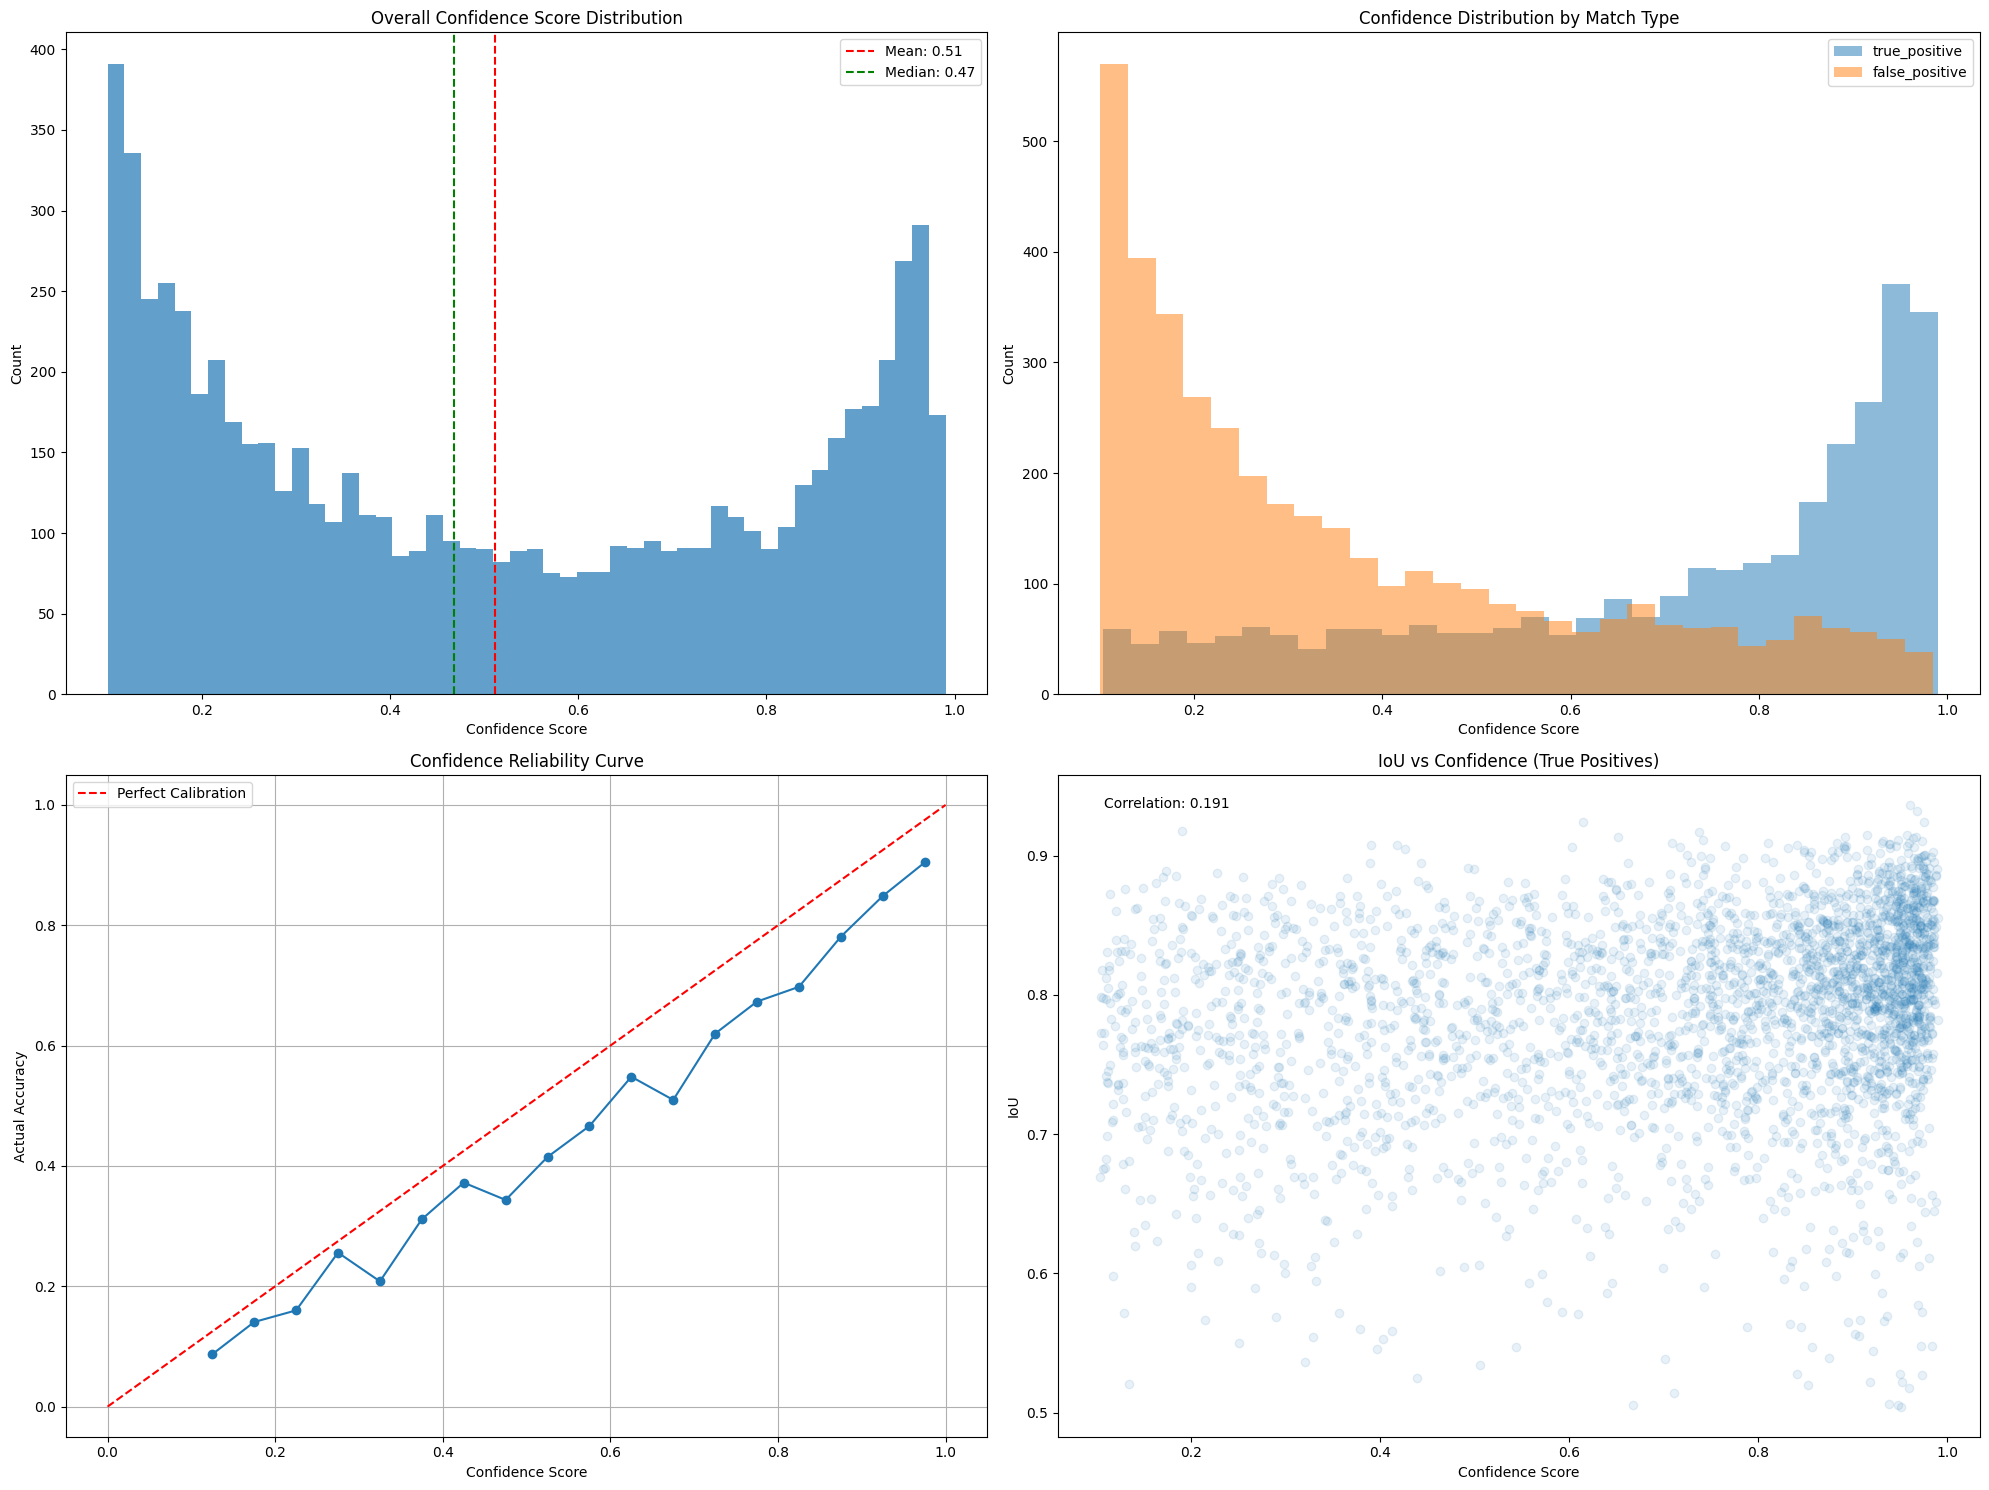

=== Confidence Score Analysis ===

Overall Confidence Statistics:
count    7118.000000
mean        0.512246
std         0.302539
min         0.100062
25%         0.218224
50%         0.468183
75%         0.820323
max         0.990468
Name: confidence, dtype: float64

Confidence by Match Type:

True Positive:
count    3111.000000
mean        0.707692
std         0.257113
min         0.103593
25%         0.524616
50%         0.798733
75%         0.926508
max         0.990468
Name: confidence, dtype: float64

False Positive:
count    4007.000000
mean        0.360504
std         0.242060
min         0.100062
25%         0.162694
50%         0.274724
75%         0.506709
max         0.984827
Name: confidence, dtype: float64

Confidence Threshold Analysis:

At confidence >= 0.1:
Precision: 0.437
Number of predictions: 7118

At confidence >= 0.2:
Precision: 0.531
Number of predictions: 5534

At confidence >= 0.3:
Precision: 0.596
Number of predictions: 4616

At confidence >= 0.4:
Precision: 0

In [61]:
# Create figure with multiple subplots
plt.figure(figsize=(20, 15))

# 1. Overall Confidence Distribution
plt.subplot(2, 2, 1)
plt.hist(matches_df['confidence'], bins=50, alpha=0.7)
plt.axvline(matches_df['confidence'].mean(), color='r', linestyle='--', 
            label=f'Mean: {matches_df["confidence"].mean():.2f}')
plt.axvline(matches_df['confidence'].median(), color='g', linestyle='--', 
            label=f'Median: {matches_df["confidence"].median():.2f}')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Overall Confidence Score Distribution')
plt.legend()

# 2. Confidence Distribution by Match Type
plt.subplot(2, 2, 2)
for match_type in ['true_positive', 'false_positive']:
    data = matches_df[matches_df['match_type'] == match_type]['confidence']
    plt.hist(data, bins=30, alpha=0.5, label=match_type)
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Confidence Distribution by Match Type')
plt.legend()

# 3. Confidence Reliability Curve
plt.subplot(2, 2, 3)
# Calculate accuracy for different confidence bins
conf_bins = np.linspace(0, 1, 21)
bin_accuracies = []
bin_centers = []

for i in range(len(conf_bins)-1):
    mask = (matches_df['confidence'] >= conf_bins[i]) & (matches_df['confidence'] < conf_bins[i+1])
    bin_data = matches_df[mask]
    if len(bin_data) > 0:
        accuracy = len(bin_data[bin_data['match_type'] == 'true_positive']) / len(bin_data)
        bin_accuracies.append(accuracy)
        bin_centers.append((conf_bins[i] + conf_bins[i+1]) / 2)

plt.plot(bin_centers, bin_accuracies, 'o-')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
plt.xlabel('Confidence Score')
plt.ylabel('Actual Accuracy')
plt.title('Confidence Reliability Curve')
plt.grid(True)
plt.legend()

# 4. IoU vs Confidence for True Positives
plt.subplot(2, 2, 4)
tp_data = matches_df[matches_df['match_type'] == 'true_positive']
plt.scatter(tp_data['confidence'], tp_data['iou'], alpha=0.1)
plt.xlabel('Confidence Score')
plt.ylabel('IoU')
plt.title('IoU vs Confidence (True Positives)')

# Calculate correlation
correlation = tp_data['confidence'].corr(tp_data['iou'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Statistical Analysis
print("=== Confidence Score Analysis ===")

print("\nOverall Confidence Statistics:")
print(matches_df['confidence'].describe())

print("\nConfidence by Match Type:")
for match_type in ['true_positive', 'false_positive']:
    print(f"\n{match_type.replace('_', ' ').title()}:")
    print(matches_df[matches_df['match_type'] == match_type]['confidence'].describe())

# Calculate optimal confidence thresholds for different criteria
print("\nConfidence Threshold Analysis:")

# Calculate precision at different confidence levels
confidence_levels = np.arange(0.1, 1.0, 0.1)
for conf in confidence_levels:
    predictions = len(matches_df[matches_df['confidence'] >= conf])
    correct = len(matches_df[(matches_df['confidence'] >= conf) & 
                           (matches_df['match_type'] == 'true_positive')])
    precision = correct / predictions if predictions > 0 else 0
    print(f"\nAt confidence >= {conf:.1f}:")
    print(f"Precision: {precision:.3f}")
    print(f"Number of predictions: {predictions}")

# Calibration analysis
print("\nCalibration Analysis:")
for i in range(len(bin_centers)):
    print(f"\nConfidence bin {bin_centers[i]:.2f}:")
    print(f"Actual accuracy: {bin_accuracies[i]:.3f}")
    print(f"Calibration error: {abs(bin_accuracies[i] - bin_centers[i]):.3f}")

# Calculate average calibration error
calibration_error = np.mean([abs(acc - conf) for acc, conf in zip(bin_accuracies, bin_centers)])
print(f"\nMean calibration error: {calibration_error:.3f}")


- Overall Distribution:
    - Annotations:
        - Mean: 76 defects per image
        - Range: 8 to 228 defects
        - High variation (std: 46.5)
    - Predictions:
        - Mean: 148 defects per image
        - Range: 14 to 358 defects
        - Even higher variation (std: 80.0)
    - Prediction/Annotation Ratio:
        - Mean ratio: 2.09 (about twice as many predictions as annotations)
        - Minimum ratio: 1.02 (model never under-predicts)
        - Maximum ratio: 4.24 (some severe over-prediction cases)
        - 54.2% of images have more than 2x predictions than annotations
    - Notable Cases:
        - Most over-predicted images:
            - Image 2014: 4.24x more predictions
            - Image 1195: 3.64x more predictions
        - Most accurately predicted images:
            - Image 1479: 1.02x ratio
            - Image 2323: 1.09x ratio
    - Class Distribution:
        - Annotations: All defects are class 7 ("Mononukleäre Zelle")
        - Predictions: All predictions are labeled as "Defect"
    - Key Insights:
        - The model consistently over-predicts across all images
        - No cases of under-prediction (ratio < 1)
        - Strong correlation between number of annotations and predictions
        - Prediction counts scale roughly linearly with annotation counts
        - This analysis suggests that:
            - The model needs better calibration to reduce false positives
            - Over-prediction is systematic but varies in severity across images
            - The model's behavior is consistent (always over-predicts) but the degree varies
        - Range: 14 to 358 defects
        - Even higher variation (std: 80.0)
    - Prediction/Annotation Ratio:
        - Mean ratio: 2.09 (about twice as many predictions as annotations)
        - Minimum ratio: 1.02 (model never under-predicts)
        - Maximum ratio: 4.24 (some severe over-prediction cases)
        - 54.2% of images have more than 2x predictions than annotations
    - Notable Cases:
        - Most over-predicted images:
            - Image 2014: 4.24x more predictions
            - Image 1195: 3.64x more predictions
        - Most accurately predicted images:
            - Image 1479: 1.02x ratio
            - Image 2323: 1.09x ratio
    - Class Distribution:
        - Annotations: All defects are class 7 ("Mononukleäre Zelle")
        - Predictions: All predictions are labeled as "Defect"
    - Key Insights:
        - The model consistently over-predicts across all images
        - No cases of under-prediction (ratio < 1)
        - Strong correlation between number of annotations and predictions
        - Prediction counts scale roughly linearly with annotation counts
        - This analysis suggests that:
            - The model needs better calibration to reduce false positives
            - Over-prediction is systematic but varies in severity across images
            - The model's behavior is consistent (always over-predicts) but the degree varies

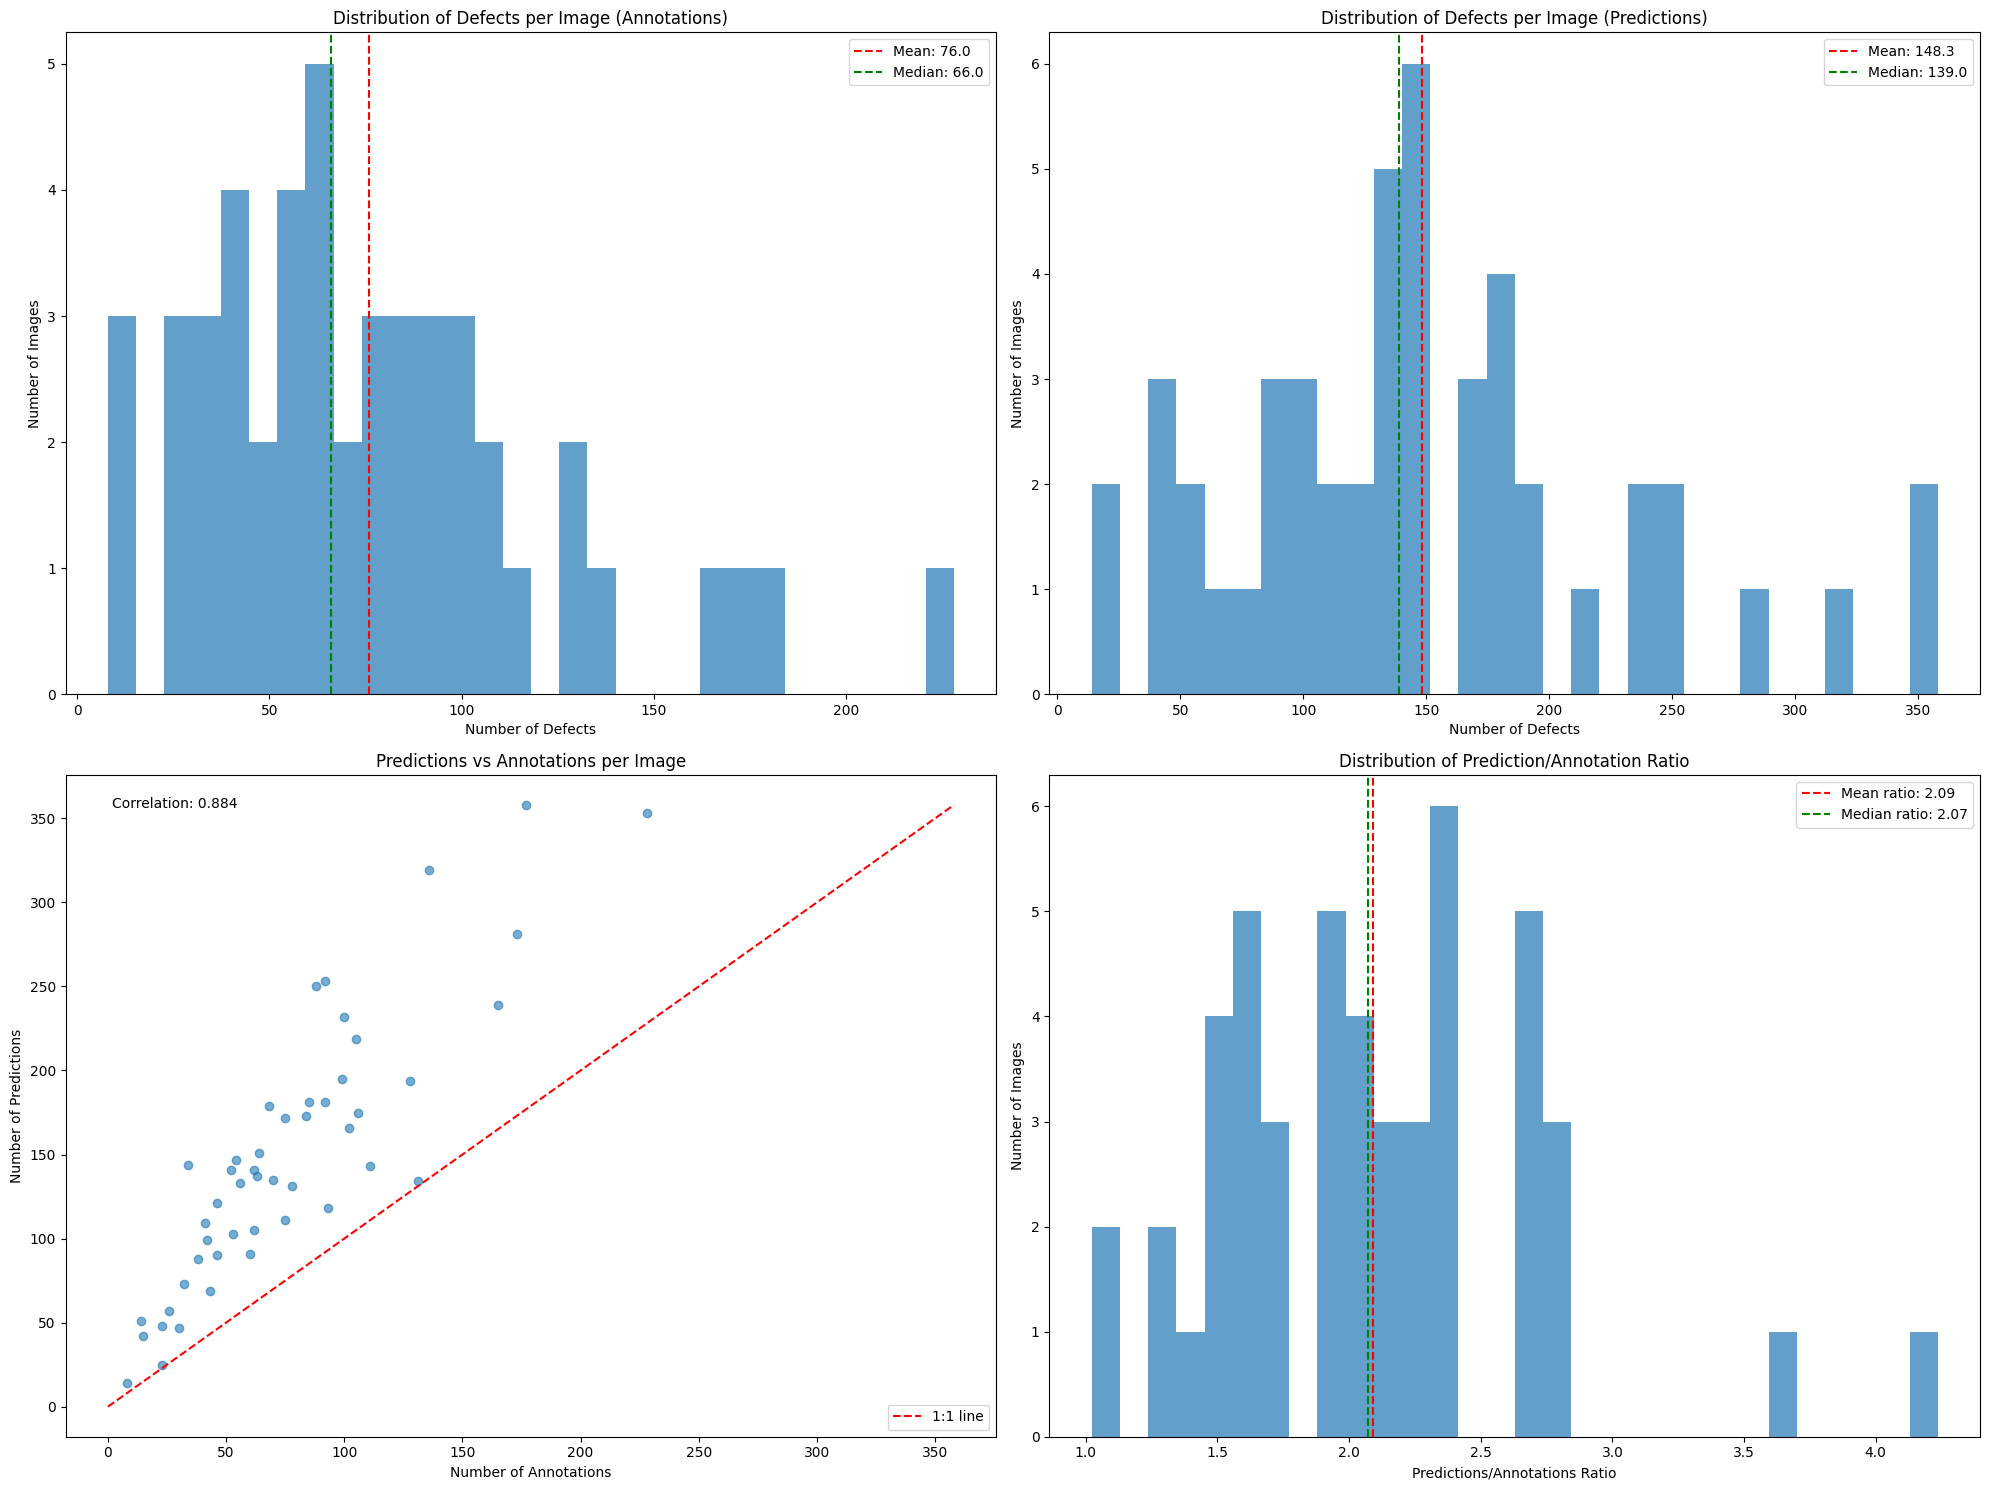

=== Defect Distribution Analysis ===

Annotations per Image:
count     48.000000
mean      76.000000
std       46.515612
min        8.000000
25%       42.750000
50%       66.000000
75%       99.250000
max      228.000000
dtype: float64

Predictions per Image:
count     48.000000
mean     148.291667
std       80.001319
min       14.000000
25%       97.000000
50%      139.000000
75%      181.000000
max      358.000000
dtype: float64

Prediction/Annotation Ratio Statistics:
count    48.000000
mean      2.092407
std       0.612115
min       1.022901
25%       1.626658
50%       2.072619
75%       2.357701
max       4.235294
dtype: float64

Over/Under Prediction Analysis:
Images with ratio > 2: 26 (54.2%)
Images with ratio < 1: 0 (0.0%)

Top 5 most over-predicted images:
Image 2014: 4.24x more predictions than annotations
Image 1195: 3.64x more predictions than annotations
Image 1726: 2.84x more predictions than annotations
Image 2304: 2.80x more predictions than annotations
Image 2862: 2.7

In [63]:
# Create figure with multiple subplots
plt.figure(figsize=(20, 15))

# 1. Distribution of defects per image in annotations
plt.subplot(2, 2, 1)
anno_per_image = anno_df.groupby('image_id').size()
plt.hist(anno_per_image, bins=30, alpha=0.7)
plt.axvline(anno_per_image.mean(), color='r', linestyle='--', 
            label=f'Mean: {anno_per_image.mean():.1f}')
plt.axvline(anno_per_image.median(), color='g', linestyle='--', 
            label=f'Median: {anno_per_image.median():.1f}')
plt.xlabel('Number of Defects')
plt.ylabel('Number of Images')
plt.title('Distribution of Defects per Image (Annotations)')
plt.legend()

# 2. Distribution of defects per image in predictions
plt.subplot(2, 2, 2)
pred_per_image = pred_df.groupby('image_id').size()
plt.hist(pred_per_image, bins=30, alpha=0.7)
plt.axvline(pred_per_image.mean(), color='r', linestyle='--', 
            label=f'Mean: {pred_per_image.mean():.1f}')
plt.axvline(pred_per_image.median(), color='g', linestyle='--', 
            label=f'Median: {pred_per_image.median():.1f}')
plt.xlabel('Number of Defects')
plt.ylabel('Number of Images')
plt.title('Distribution of Defects per Image (Predictions)')
plt.legend()

# 3. Comparison of defect counts per image
plt.subplot(2, 2, 3)
# Create a DataFrame with both counts
comparison_df = pd.DataFrame({
    'Annotations': anno_per_image,
    'Predictions': pred_per_image
})
plt.scatter(comparison_df['Annotations'], comparison_df['Predictions'], alpha=0.6)
max_val = max(comparison_df.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 line')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Predictions')
plt.title('Predictions vs Annotations per Image')
plt.legend()

# Calculate correlation
correlation = comparison_df['Annotations'].corr(comparison_df['Predictions'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes)

# 4. Ratio of predictions to annotations per image
plt.subplot(2, 2, 4)
ratio = comparison_df['Predictions'] / comparison_df['Annotations']
plt.hist(ratio, bins=30, alpha=0.7)
plt.axvline(ratio.mean(), color='r', linestyle='--', 
            label=f'Mean ratio: {ratio.mean():.2f}')
plt.axvline(ratio.median(), color='g', linestyle='--', 
            label=f'Median ratio: {ratio.median():.2f}')
plt.xlabel('Predictions/Annotations Ratio')
plt.ylabel('Number of Images')
plt.title('Distribution of Prediction/Annotation Ratio')
plt.legend()

plt.tight_layout()
plt.show()

# Print detailed statistics
print("=== Defect Distribution Analysis ===")

print("\nAnnotations per Image:")
print(anno_per_image.describe())

print("\nPredictions per Image:")
print(pred_per_image.describe())

print("\nPrediction/Annotation Ratio Statistics:")
print(ratio.describe())

# Analyze over/under prediction patterns
print("\nOver/Under Prediction Analysis:")
print(f"Images with ratio > 2: {len(ratio[ratio > 2])} ({len(ratio[ratio > 2])/len(ratio)*100:.1f}%)")
print(f"Images with ratio < 1: {len(ratio[ratio < 1])} ({len(ratio[ratio < 1])/len(ratio)*100:.1f}%)")

# Find images with extreme ratios
print("\nTop 5 most over-predicted images:")
top_ratio = ratio.sort_values(ascending=False).head()
for img_id, r in top_ratio.items():
    print(f"Image {img_id}: {r:.2f}x more predictions than annotations")

print("\nImages with most similar prediction counts:")
closest_to_one = ratio.sort_values(key=lambda x: abs(x-1)).head()
for img_id, r in closest_to_one.items():
    print(f"Image {img_id}: {r:.2f}x ratio")


#### **Analyze Patterns in the spatial distribution of defects**

- Defect Size Distribution:
    - Annotations:
        - Mean area: 1,119 pixels²
        - Range: 78 to 8,254 pixels²
        - Relatively consistent sizes (std: 739)
    - Predictions:
        - Mean area: 1,114 pixels² (very close to annotations)
        - Range: 20 to 15,479 pixels²
        - More variable sizes (std: 832)
        - Some predictions are much larger than any real defect
- Spatial Clustering:
    - Mean distance to nearest neighbor: 94 pixels
    - High variability in spacing (std: 83 pixels)
    - Closest defects: 24 pixels apart
    - Most isolated defects: 557 pixels from neighbors
    - Clear evidence of clustering behavior
- Spatial Distribution (for sample image):
    - Highly uneven distribution across quadrants:
        - Top Left: 34.7% of defects
        - Top Right: 28.0% of defects
        - Bottom Left: 34.7% of defects
        - Bottom Right: only 2.7% of defects
    - Strong bias against bottom-right quadrant
- Key Patterns:
    - Defects tend to cluster in groups
    - Significant spatial bias in distribution
    - Model preserves mean defect size but allows more extreme variations
    - Clear evidence of non-random spatial organization
- Implications:
The model should consider spatial context more strongly
Over-prediction might be reduced by considering typical inter-defect distances
Size constraints could help eliminate unrealistically large predictions
The strong spatial bias suggests underlying image features influence defect locations

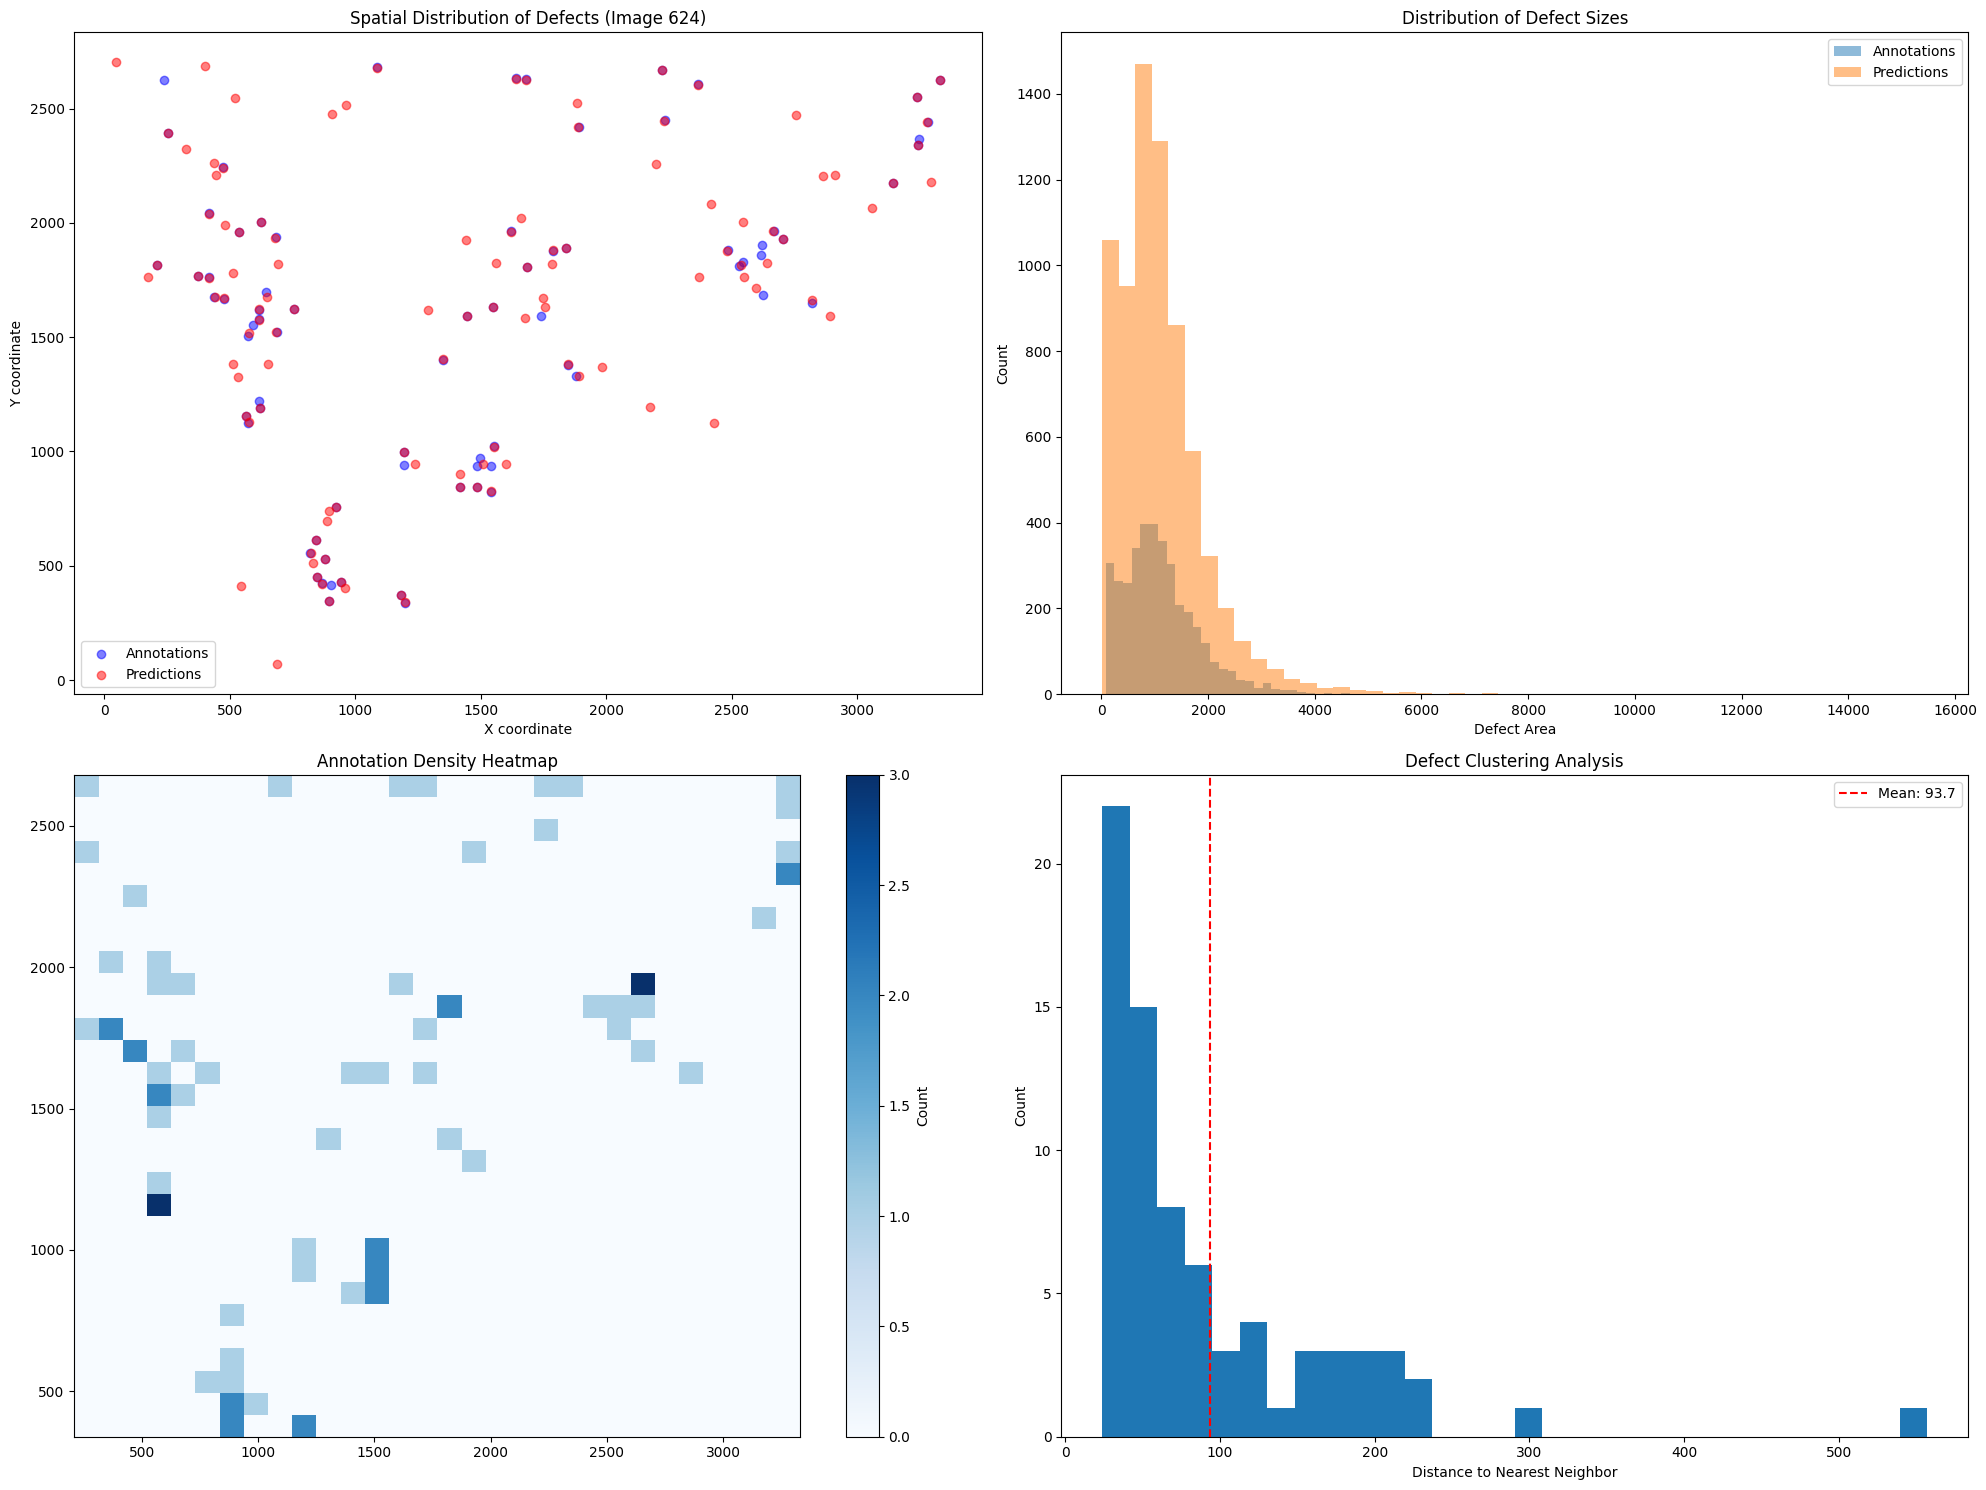

=== Spatial Pattern Analysis ===

Defect Size Statistics:

Annotations:
Mean area: 1119.11
Std area: 738.92
Min area: 78.25
Max area: 8254.21

Predictions:
Mean area: 1113.63
Std area: 831.58
Min area: 19.60
Max area: 15479.32

Clustering Analysis:
Mean distance to nearest neighbor: 93.71
Std distance: 82.89
Min distance: 23.94
Max distance: 557.16

Spatial Distribution (Annotations):
Top Left: 26 defects (34.7%)
Top Right: 21 defects (28.0%)
Bottom Left: 26 defects (34.7%)
Bottom Right: 2 defects (2.7%)


In [64]:
def parse_coordinates(xy_str):
    """Convert string coordinates to list of tuples"""
    try:
        if isinstance(xy_str, str):
            if xy_str.startswith('['):
                coords = ast.literal_eval(xy_str)
            else:
                coords = [float(x) for x in xy_str.split(',')]
            return list(zip(coords[::2], coords[1::2]))
    except:
        return None

def get_polygon_centroid(coords):
    """Calculate centroid of a polygon"""
    try:
        poly = Polygon(coords)
        return poly.centroid.x, poly.centroid.y
    except:
        return None

def get_polygon_area(coords):
    """Calculate area of a polygon"""
    try:
        poly = Polygon(coords)
        return poly.area
    except:
        return None

# Create figure for spatial analysis
plt.figure(figsize=(20, 15))

# Process a sample image to demonstrate spatial patterns
sample_image_id = anno_df['image_id'].iloc[0]

# 1. Spatial Distribution Plot
plt.subplot(2, 2, 1)
anno_image = anno_df[anno_df['image_id'] == sample_image_id]
pred_image = pred_df[pred_df['image_id'] == sample_image_id]

# Plot centroids
anno_centroids = []
pred_centroids = []

for _, row in anno_image.iterrows():
    coords = parse_coordinates(row['xy'])
    if coords:
        centroid = get_polygon_centroid(coords)
        if centroid:
            anno_centroids.append(centroid)

for _, row in pred_image.iterrows():
    coords = parse_coordinates(row['xy'])
    if coords:
        centroid = get_polygon_centroid(coords)
        if centroid:
            pred_centroids.append(centroid)

anno_centroids = np.array(anno_centroids)
pred_centroids = np.array(pred_centroids)

if len(anno_centroids) > 0:
    plt.scatter(anno_centroids[:, 0], anno_centroids[:, 1], 
               alpha=0.5, label='Annotations', c='blue')
if len(pred_centroids) > 0:
    plt.scatter(pred_centroids[:, 0], pred_centroids[:, 1], 
               alpha=0.5, label='Predictions', c='red')

plt.title(f'Spatial Distribution of Defects (Image {sample_image_id})')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()

# 2. Defect Size Distribution
plt.subplot(2, 2, 2)
anno_areas = []
pred_areas = []

for _, row in anno_df.iterrows():
    coords = parse_coordinates(row['xy'])
    if coords:
        area = get_polygon_area(coords)
        if area:
            anno_areas.append(area)

for _, row in pred_df.iterrows():
    coords = parse_coordinates(row['xy'])
    if coords:
        area = get_polygon_area(coords)
        if area:
            pred_areas.append(area)

plt.hist(anno_areas, bins=50, alpha=0.5, label='Annotations')
plt.hist(pred_areas, bins=50, alpha=0.5, label='Predictions')
plt.xlabel('Defect Area')
plt.ylabel('Count')
plt.title('Distribution of Defect Sizes')
plt.legend()

# 3. Spatial Density Heatmap
plt.subplot(2, 2, 3)
if len(anno_centroids) > 0:
    plt.hist2d(anno_centroids[:, 0], anno_centroids[:, 1], bins=30, cmap='Blues')
plt.title('Annotation Density Heatmap')
plt.colorbar(label='Count')

# 4. Distance Analysis
plt.subplot(2, 2, 4)
if len(anno_centroids) > 0:
    # Calculate nearest neighbor distances
    distances = []
    for i, centroid in enumerate(anno_centroids):
        other_centroids = np.delete(anno_centroids, i, axis=0)
        if len(other_centroids) > 0:
            dist = np.min(np.sqrt(np.sum((other_centroids - centroid)**2, axis=1)))
            distances.append(dist)
    
    plt.hist(distances, bins=30)
    plt.axvline(np.mean(distances), color='r', linestyle='--', 
                label=f'Mean: {np.mean(distances):.1f}')
    plt.xlabel('Distance to Nearest Neighbor')
    plt.ylabel('Count')
    plt.title('Defect Clustering Analysis')
    plt.legend()

plt.tight_layout()
plt.show()
# Print statistical analysis
print("=== Spatial Pattern Analysis ===")

# Analyze areas
print("\nDefect Size Statistics:")
print("\nAnnotations:")
print(f"Mean area: {np.mean(anno_areas):.2f}")
print(f"Std area: {np.std(anno_areas):.2f}")
print(f"Min area: {np.min(anno_areas):.2f}")
print(f"Max area: {np.max(anno_areas):.2f}")

print("\nPredictions:")
print(f"Mean area: {np.mean(pred_areas):.2f}")
print(f"Std area: {np.std(pred_areas):.2f}")
print(f"Min area: {np.min(pred_areas):.2f}")
print(f"Max area: {np.max(pred_areas):.2f}")

# Analyze spatial clustering
if len(distances) > 0:
    print("\nClustering Analysis:")
    print(f"Mean distance to nearest neighbor: {np.mean(distances):.2f}")
    print(f"Std distance: {np.std(distances):.2f}")
    print(f"Min distance: {np.min(distances):.2f}")
    print(f"Max distance: {np.max(distances):.2f}")

# Analyze distribution across image regions
if len(anno_centroids) > 0:
    # Divide image into quadrants
    x_mid = (np.max(anno_centroids[:, 0]) + np.min(anno_centroids[:, 0])) / 2
    y_mid = (np.max(anno_centroids[:, 1]) + np.min(anno_centroids[:, 1])) / 2
    
    quadrants = {
        'Top Left': ((anno_centroids[:, 0] < x_mid) & (anno_centroids[:, 1] > y_mid)).sum(),
        'Top Right': ((anno_centroids[:, 0] >= x_mid) & (anno_centroids[:, 1] > y_mid)).sum(),
        'Bottom Left': ((anno_centroids[:, 0] < x_mid) & (anno_centroids[:, 1] <= y_mid)).sum(),
        'Bottom Right': ((anno_centroids[:, 0] >= x_mid) & (anno_centroids[:, 1] <= y_mid)).sum()
    }
    
    print("\nSpatial Distribution (Annotations):")
    for quadrant, count in quadrants.items():
        print(f"{quadrant}: {count} defects ({count/len(anno_centroids)*100:.1f}%)")


#### **Analyze relationships between image characteristics and over-prediction rate**

- **Confidence Score Relationship:**
    - Weak negative correlation (-0.251) between average confidence and over-prediction rate
    - Higher confidence slightly correlates with lower over-prediction
    - Regression analysis shows:
        - Slope: -2.349 (decreasing over-prediction with increasing confidence)
        - Low R-squared (0.063): confidence alone explains little of the variation
        - Marginally significant (p-value: 0.085)
- **Image Complexity (Number of Annotations):**
    - Moderate negative correlation (-0.385) between number of annotations and over-prediction rate
    - Strong positive correlation (0.884) between annotations and predictions
    - Images with fewer annotations tend to have higher over-prediction rates
    - The model maintains relative proportions better in complex images
- **Confidence Level Patterns:**
    - Very Low confidence bin:
        - Highest mean over-prediction rate (2.42)
        - Highest variability (std: 0.56)
    - Medium confidence bin:
        - Lowest mean over-prediction rate (1.90)
        - More consistent predictions
- **Extreme Cases:**
    - Highest over-prediction (Image 2014):
        - 4.24x ratio
        - Below average confidence (0.474)
        - Few annotations (34)
    - Lowest over-prediction (Image 1479):
        - 1.02x ratio
        - Average confidence (0.488)
        - Many annotations (131)
- **Key Patterns:**
    - Over-prediction is more severe in images with:
        - Fewer annotations
        - Lower confidence scores
        - Less complex defect patterns
    - More accurate predictions occur in images with:
        - More annotations
        - Medium to high confidence
        - More complex defect patterns
- **Recommendations:**
    - Focus model improvements on images with fewer defects
    - Consider implementing confidence thresholds based on image complexity
    - Investigate why the model over-predicts more in simpler images
    - Use annotation count as a potential factor in confidence calibration

/var/folders/jn/0b_xwd412532nmd6152zbw1w0000gp/T/ipykernel_3160/2249274612.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=metrics_df['confidence_bin'].unique())


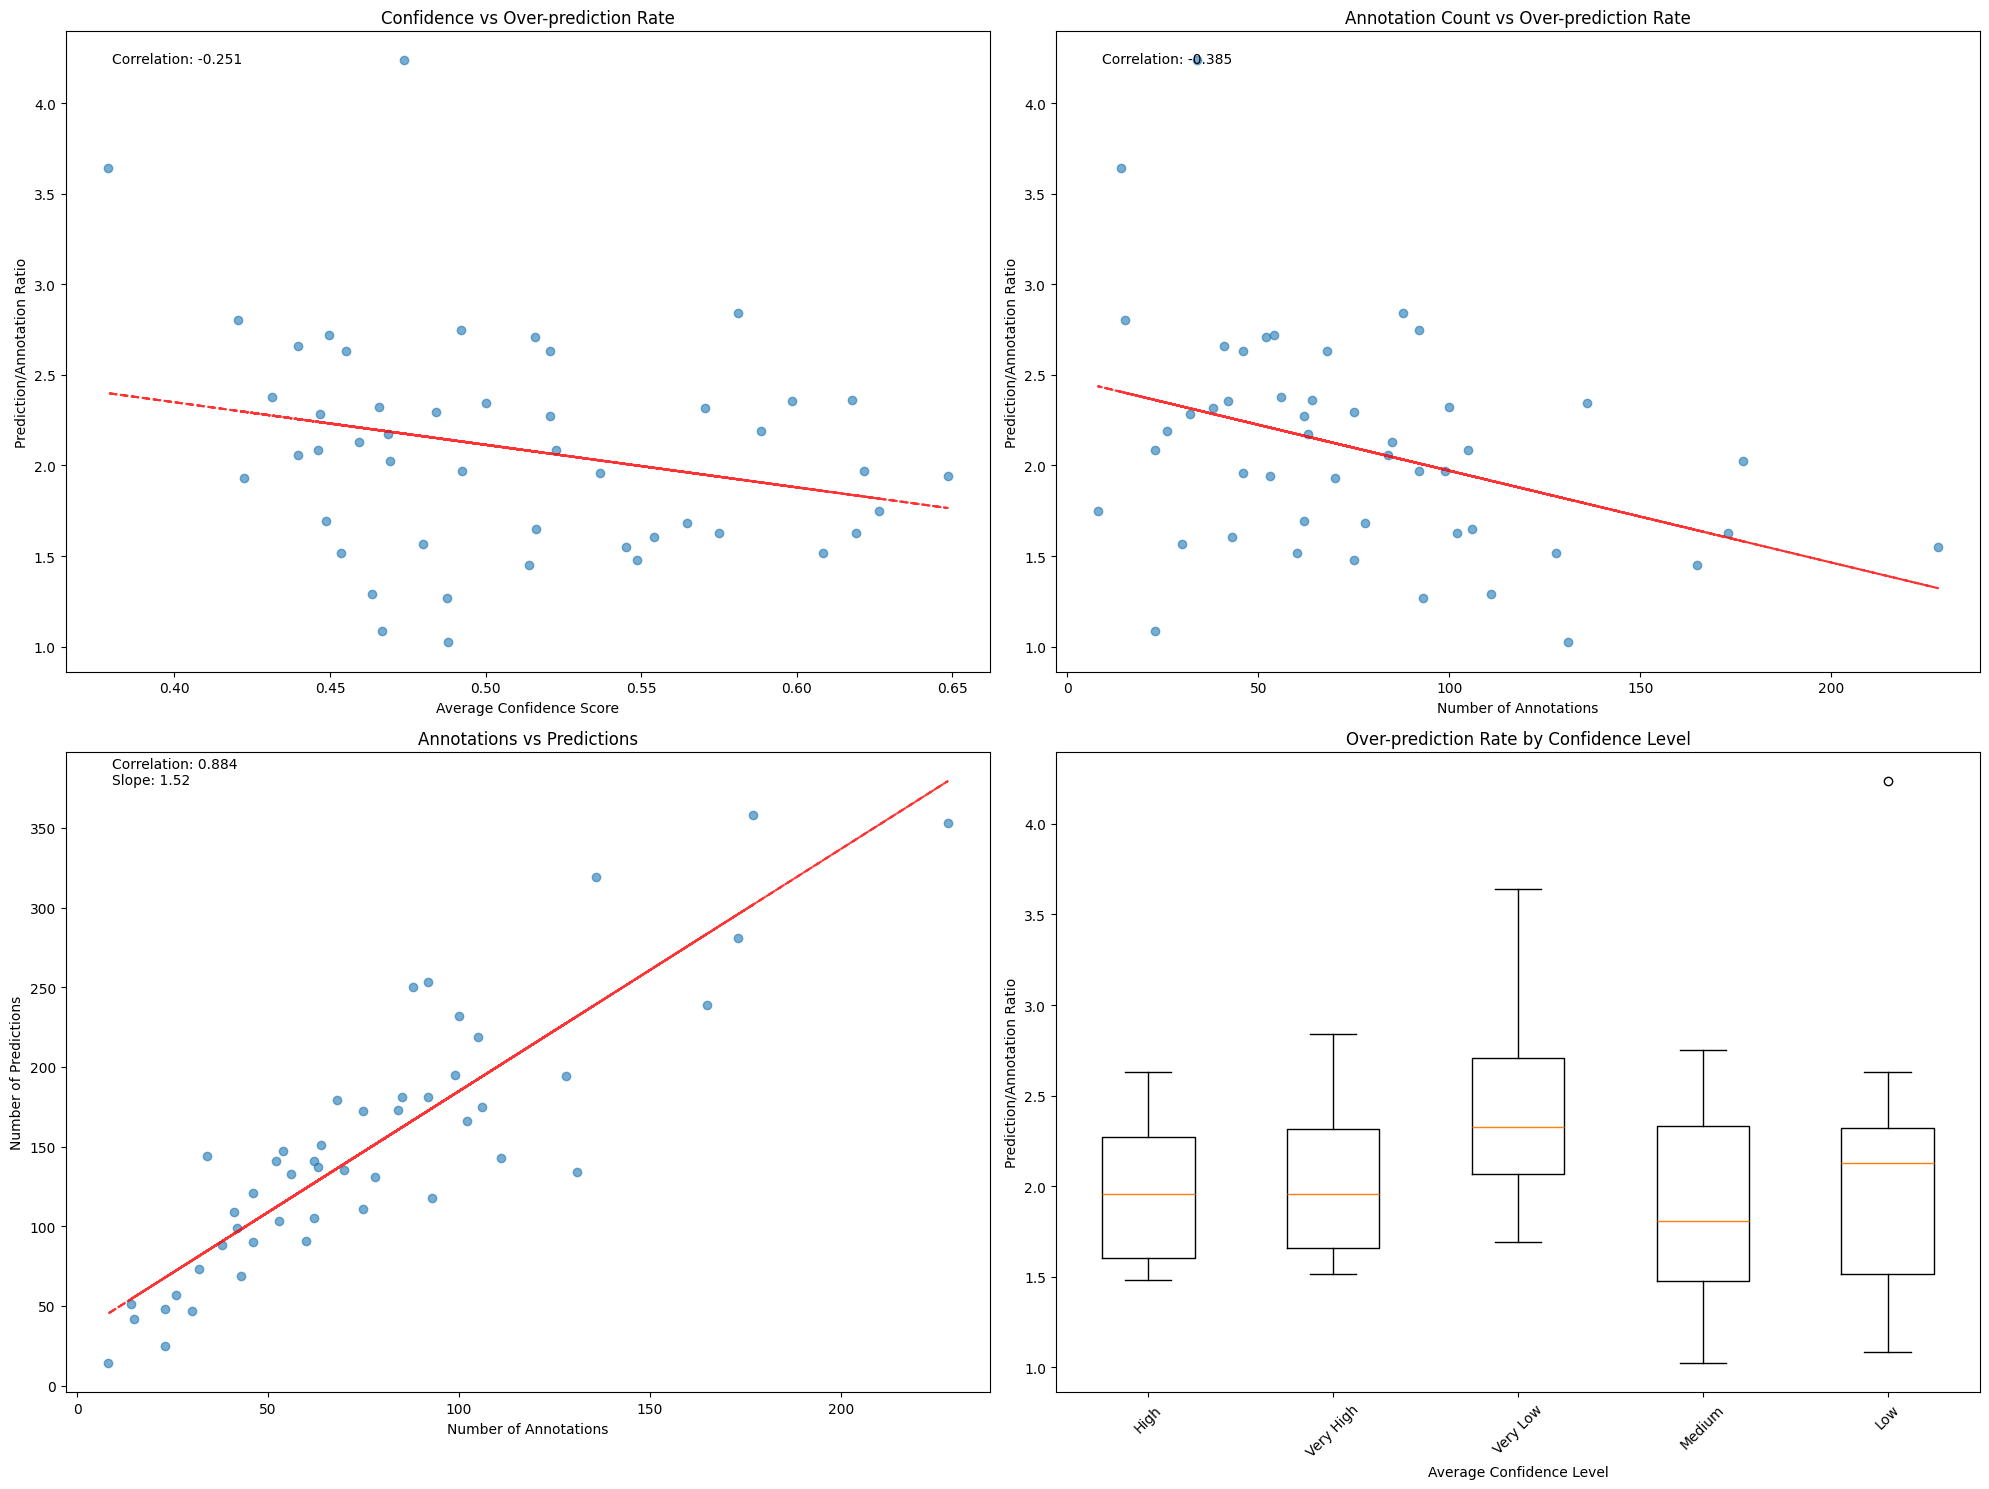

=== Statistical Analysis of Prediction Patterns ===

Basic Statistics:
          image_id  avg_confidence  n_predictions  n_annotations  \
count    48.000000       48.000000      48.000000      48.000000   
mean   1844.500000        0.509089     148.291667      76.000000   
std     801.153716        0.065461      80.001319      46.515612   
min     624.000000        0.378538      14.000000       8.000000   
25%    1198.000000        0.458177      97.000000      42.750000   
50%    2013.000000        0.492381     139.000000      66.000000   
75%    2316.500000        0.556822     181.000000      99.250000   
max    3165.000000        0.648455     358.000000     228.000000   

       pred_anno_ratio  
count        48.000000  
mean          2.092407  
std           0.612115  
min           1.022901  
25%           1.626658  
50%           2.072619  
75%           2.357701  
max           4.235294  

Correlation Analysis:
Confidence vs Over-prediction: -0.251
Annotations vs Over-prediction

/var/folders/jn/0b_xwd412532nmd6152zbw1w0000gp/T/ipykernel_3160/2249274612.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(metrics_df.groupby('confidence_bin')['pred_anno_ratio'].describe())


In [66]:
# Read the metrics data
metrics_df = pd.read_csv('image_metrics.csv')

# Create figure for analysis
plt.figure(figsize=(20, 15))

# 1. Relationship between average confidence and over-prediction ratio
plt.subplot(2, 2, 1)
plt.scatter(metrics_df['avg_confidence'], metrics_df['pred_anno_ratio'], alpha=0.6)
plt.xlabel('Average Confidence Score')
plt.ylabel('Prediction/Annotation Ratio')
plt.title('Confidence vs Over-prediction Rate')

# Add trend line
z = np.polyfit(metrics_df['avg_confidence'], metrics_df['pred_anno_ratio'], 1)
p = np.poly1d(z)
plt.plot(metrics_df['avg_confidence'], p(metrics_df['avg_confidence']), "r--", alpha=0.8)

# Add correlation coefficient
corr = metrics_df['avg_confidence'].corr(metrics_df['pred_anno_ratio'])
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes)

# 2. Relationship between number of annotations and over-prediction ratio
plt.subplot(2, 2, 2)
plt.scatter(metrics_df['n_annotations'], metrics_df['pred_anno_ratio'], alpha=0.6)
plt.xlabel('Number of Annotations')
plt.ylabel('Prediction/Annotation Ratio')
plt.title('Annotation Count vs Over-prediction Rate')

# Add trend line
z = np.polyfit(metrics_df['n_annotations'], metrics_df['pred_anno_ratio'], 1)
p = np.poly1d(z)
plt.plot(metrics_df['n_annotations'], p(metrics_df['n_annotations']), "r--", alpha=0.8)

# Add correlation coefficient
corr = metrics_df['n_annotations'].corr(metrics_df['pred_anno_ratio'])
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes)

# 3. Relationship between predictions and annotations
plt.subplot(2, 2, 3)
plt.scatter(metrics_df['n_annotations'], metrics_df['n_predictions'], alpha=0.6)
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Predictions')
plt.title('Annotations vs Predictions')

# Add trend line
z = np.polyfit(metrics_df['n_annotations'], metrics_df['n_predictions'], 1)
p = np.poly1d(z)
plt.plot(metrics_df['n_annotations'], p(metrics_df['n_annotations']), "r--", alpha=0.8)

# Add correlation coefficient and slope
corr = metrics_df['n_annotations'].corr(metrics_df['n_predictions'])
slope = z[0]
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}\nSlope: {slope:.2f}', transform=plt.gca().transAxes)

# 4. Distribution of prediction ratios by confidence bins
plt.subplot(2, 2, 4)
metrics_df['confidence_bin'] = pd.qcut(metrics_df['avg_confidence'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
box_data = [metrics_df[metrics_df['confidence_bin'] == bin]['pred_anno_ratio'] for bin in metrics_df['confidence_bin'].unique()]
plt.boxplot(box_data, labels=metrics_df['confidence_bin'].unique())
plt.xlabel('Average Confidence Level')
plt.ylabel('Prediction/Annotation Ratio')
plt.title('Over-prediction Rate by Confidence Level')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Statistical Analysis
print("=== Statistical Analysis of Prediction Patterns ===\n")

# 1. Basic Statistics
print("Basic Statistics:")
print(metrics_df.describe())

# 2. Correlation Analysis
print("\nCorrelation Analysis:")
correlations = {
    'Confidence vs Over-prediction': metrics_df['avg_confidence'].corr(metrics_df['pred_anno_ratio']),
    'Annotations vs Over-prediction': metrics_df['n_annotations'].corr(metrics_df['pred_anno_ratio']),
    'Annotations vs Predictions': metrics_df['n_annotations'].corr(metrics_df['n_predictions'])
}
for pair, corr in correlations.items():
    print(f"{pair}: {corr:.3f}")

# 3. Confidence Level Analysis
print("\nOver-prediction Rate by Confidence Level:")
print(metrics_df.groupby('confidence_bin')['pred_anno_ratio'].describe())

# 4. Regression Analysis
from scipy import stats

# Confidence vs Over-prediction
slope, intercept, r_value, p_value, std_err = stats.linregress(metrics_df['avg_confidence'], metrics_df['pred_anno_ratio'])
print("\nRegression Analysis - Confidence vs Over-prediction:")
print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value:.3f}")

# 5. Identify Extreme Cases
print("\nExtreme Cases Analysis:")
print("\nHighest Over-prediction Rates:")
print(metrics_df.nlargest(5, 'pred_anno_ratio')[['image_id', 'avg_confidence', 'n_predictions', 'n_annotations', 'pred_anno_ratio']])

print("\nLowest Over-prediction Rates:")
print(metrics_df.nsmallest(5, 'pred_anno_ratio')[['image_id', 'avg_confidence', 'n_predictions', 'n_annotations', 'pred_anno_ratio']])


In [10]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from shapely.geometry import Polygon
# from sklearn.metrics import precision_recall_curve, auc
# import ast

# # Helper functions
# def string_to_coords(xy_str):
#     """Convert string coordinates to list of tuples"""
#     try:
#         # Handle string representations of lists
#         if xy_str.startswith('['):
#             coords = ast.literal_eval(xy_str)
#             return list(zip(coords[::2], coords[1::2]))
        
#         # Handle comma-separated string
#         coords = [float(x) for x in xy_str.split(',')]
#         return list(zip(coords[::2], coords[1::2]))
#     except:
#         return None

# def calculate_iou(poly1_coords, poly2_coords):
#     """Calculate IoU between two polygons"""
#     try:
#         poly1 = Polygon(poly1_coords)
#         poly2 = Polygon(poly2_coords)
        
#         if not (poly1.is_valid and poly2.is_valid):
#             return 0
        
#         intersection_area = poly1.intersection(poly2).area
#         union_area = poly1.union(poly2).area
        
#         if union_area == 0:
#             return 0
            
#         return intersection_area / union_area
#     except:
#         return 0

# def evaluate_threshold(anno_df, pred_df, confidence_threshold, iou_threshold=0.5):
#     """Evaluate model performance at a given confidence threshold"""
#     # Filter predictions by confidence
#     filtered_preds = pred_df[pred_df['confidence'] >= confidence_threshold]
    
#     true_positives = 0
#     false_positives = 0
#     false_negatives = 0
    
#     # Group by image_id for faster processing
#     pred_by_image = filtered_preds.groupby('image_id')
#     anno_by_image = anno_df.groupby('image_id')
    
#     processed_images = set(anno_df['image_id'].unique())
    
#     for image_id in processed_images:
#         image_preds = pred_by_image.get_group(image_id) if image_id in pred_by_image.groups else pd.DataFrame()
#         image_annos = anno_by_image.get_group(image_id) if image_id in anno_by_image.groups else pd.DataFrame()
        
#         matched_annos = set()
        
#         # For each prediction in the image
#         for _, pred in image_preds.iterrows():
#             pred_coords = string_to_coords(pred['xy'])
#             if not pred_coords:
#                 continue
                
#             best_iou = 0
#             best_anno_idx = None
            
#             # Find the best matching annotation
#             for idx, anno in image_annos.iterrows():
#                 if idx in matched_annos:
#                     continue
                    
#                 anno_coords = string_to_coords(anno['xy'])
#                 if not anno_coords:
#                     continue
                
#                 iou = calculate_iou(pred_coords, anno_coords)
#                 if iou > best_iou:
#                     best_iou = iou
#                     best_anno_idx = idx
            
#             # If we found a match above the IoU threshold
#             if best_iou >= iou_threshold:
#                 true_positives += 1
#                 matched_annos.add(best_anno_idx)
#             else:
#                 false_positives += 1
        
#         # Count unmatched annotations as false negatives
#         false_negatives += len(image_annos) - len(matched_annos)
    
#     precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
#     recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
#     f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
#     return {
#         'threshold': confidence_threshold,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#         'true_positives': true_positives,
#         'false_positives': false_positives,
#         'false_negatives': false_negatives
#     }

# # Load datasets
# anno_df = pd.read_csv('data/anno_df.csv')
# pred_df = pd.read_csv('data/pred_df.csv')

# # Evaluate range of thresholds
# thresholds = np.arange(0.1, 1.0, 0.1)
# results = []

# for threshold in thresholds:
#     print(f"Evaluating threshold: {threshold:.1f}")
#     result = evaluate_threshold(anno_df, pred_df, threshold)
#     results.append(result)

# # Convert results to DataFrame
# results_df = pd.DataFrame(results)

# # Plot metrics vs threshold
# plt.figure(figsize=(10, 6))
# plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
# plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
# plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
# plt.xlabel('Confidence Threshold')
# plt.ylabel('Score')
# plt.title('Model Performance Metrics vs Confidence Threshold')
# plt.legend()
# plt.grid(True)
# plt.savefig('performance_metrics.png')
# plt.close()

# # Find optimal threshold (maximum F1 score)
# optimal_result = results_df.loc[results_df['f1'].idxmax()]
# print("\nOptimal Threshold Results:")
# print(f"Confidence Threshold: {optimal_result['threshold']:.3f}")
# print(f"Precision: {optimal_result['precision']:.3f}")
# print(f"Recall: {optimal_result['recall']:.3f}")
# print(f"F1 Score: {optimal_result['f1']:.3f}")

# # Additional analysis for improvements
# print("\nAnalysis for Improvements:")

# # 1. Class distribution
# print("\nClass distribution in annotations:")
# print(anno_df['label'].value_counts())

# # 2. Confidence distribution
# plt.figure(figsize=(10, 6))
# sns.histplot(data=pred_df, x='confidence', bins=50)
# plt.title('Distribution of Prediction Confidences')
# plt.xlabel('Confidence Score')
# plt.ylabel('Count')
# plt.savefig('confidence_distribution.png')
# plt.close()

# # 3. Image-wise performance
# image_metrics = []
# for image_id in anno_df['image_id'].unique():
#     image_annos = anno_df[anno_df['image_id'] == image_id]
#     image_preds = pred_df[pred_df['image_id'] == image_id]
    
#     if len(image_preds) > 0:
#         avg_conf = image_preds['confidence'].mean()
#         n_preds = len(image_preds)
#         n_annos = len(image_annos)
        
#         image_metrics.append({
#             'image_id': image_id,
#             'avg_confidence': avg_conf,
#             'n_predictions': n_preds,
#             'n_annotations': n_annos,
#             'pred_anno_ratio': n_preds / n_annos if n_annos > 0 else float('inf')
#         })

# image_metrics_df = pd.DataFrame(image_metrics)

# # Save analysis results
# results_df.to_csv('threshold_results.csv', index=False)
# image_metrics_df.to_csv('image_metrics.csv', index=False)